# 0.0 Imports

In [1]:
import pandas   as pd
import inflection
import math
import numpy    as np
import seaborn  as sns
import datetime as datetime
import xgboost  as xgb
import random
import warnings
import pickle

from boruta                import BorutaPy
from IPython.core.display  import HTML
from IPython.display       import Image
from scipy                 import stats  as ss
from matplotlib            import pyplot as plt

from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics       import mean_absolute_error, mean_squared_error

warnings.filterwarnings( 'ignore' )

## 0.1 Helper Functions

In [2]:
def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format(k ))
        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)
        
        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]
        
        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 )
        ytraining = training['sales']
    
        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']
        
        #model
        m = model.fit( xtraining, ytraining)
        
        # prediction
        yhat = m.predict( xvalidation)
    
        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation), np.expm1(yhat) )
        
        # store performance of each kfold iteraction
        mae_list.append(m_result['MAE'] )
        mape_list.append(m_result['MAPE'] )
        rmse_list.append(m_result['RMSE'] )
        
    return pd.DataFrame( {
                          'MAE CV': np.round( np.mean( mae_list), 2).astype( str ) + ' +/- ' + np.round( np.std( mae_list), 2).astype( str ), 
                          'MAPE CV': np.round( np.mean( mape_list), 2).astype( str ) + ' +/- ' + np.round( np.std( mape_list), 2).astype( str ), 
                          'RMSE CV': np.round( np.mean( rmse_list), 2).astype( str ) + ' +/- ' + np.round( np.std( rmse_list), 2).astype( str ) }, index=[0] )


def mean_percentage_error( y, yhat):
    return np.mean( (y - yhat) / y ) 


def mean_absolute_percentage_error( y, yhat):
    return np.mean( np.abs( (y - yhat) / y ) )
        
    
def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat )
    mape = mean_absolute_percentage_error( y, yhat)
    rmse = np.sqrt(mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( {'Modelo Name': model_name,
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSE': rmse }, index=[0] )

def cramer_v(x,y):
    cm = pd.crosstab( x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corre = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorre = k - (k-1)**2/(n-1)
    rcorre = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corre/n) / ( min(kcorre-1, rcorre-1 ) ) )


def jupyter_settings():
    %matplotlib inline
    %matplotlib inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width: 100% !important; }</style' ) )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False)
    
    sns.set()


In [3]:
def jupyter_settings():
    %matplotlib inline

    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24

    display(HTML('<style>.conteiner{width:100% !important;}</style>'))

    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    # configura o pandas para quantidade de casas decimeis
    pd.set_option('display.float_format', lambda x: '%.2f' % x)

    sns.set()
jupyter_settings()

## 0.2 Loading data

In [4]:
#reading csv files
df_sales_raw = pd.read_csv("C:/Users/Leonardo2/Documents/repos/DS_producao/data/train.csv", low_memory=False)
df_store_raw = pd.read_csv("C:/Users/Leonardo2/Documents/repos/DS_producao/data/store.csv", low_memory=False)

#merging files
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store' )

# 1.0 PASSO 01 - DESCRICAO DOS DADOS

## 1.1 Rename Columns

In [5]:
df1 = df_raw.copy()

In [6]:
#bringing columns names
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth',
                             'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

#renaming columns
snakecase = lambda x: inflection.underscore(x)

cols_new = list(map (snakecase, cols_old))
                              
df1.columns = cols_new

## 1.2 Data Dimensions

In [7]:
#method to know the number of rows and cols
print( 'Number of Rows: {}'.format(df1.shape[0] ) )
print( 'Number of Columns: {}'.format(df1.shape[1] ) )

Number of Rows: 1017209
Number of Columns: 18


## 1.3 Data types

In [8]:
#knowing data types and change what is needed
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

In [9]:
df1['date'].min()

Timestamp('2013-01-01 00:00:00')

## 1.4 Check NA

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [11]:
df1['competition_distance'].max()

75860.0

In [12]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month   
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan( x['competition_open_since_month']) else x["competition_open_since_month"], axis = 1)

#competition_open_since_year    
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)
                       
# promo2_since_week  
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan( x['promo2_since_week']) else x['promo2_since_week'], axis = 1)

# promo2_since_year    
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['promo2_since_year']) else x['promo2_since_year'], axis = 1)

# promo_interval
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace = True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis =1)


## 1.6 Change Types

In [13]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( 'int64' )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( 'int64' )
df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

## 1.7 Descriptive Statistical


In [14]:
num_attributes = df1.select_dtypes(include =['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude =['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [15]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame(num_attributes.apply( np.median ) ).T

#Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame(num_attributes.apply( min ) ).T
d3 = pd.DataFrame(num_attributes.apply( max ) ).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew ()) ).T
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis ()) ).T

# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes','min', 'max', ' range', 'mean', 'median', 'std', 'skew', 'kurtosis']

m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.00,1115.00,1114.00,558.43,558.00,321.91,-0.00,-1.20
1,day_of_week,1.00,7.00,6.00,4.00,4.00,2.00,0.00,-1.25
2,sales,0.00,41551.00,41551.00,5773.82,5744.00,3849.92,0.64,1.78
3,customers,0.00,7388.00,7388.00,633.15,609.00,464.41,1.60,7.09
4,open,0.00,1.00,1.00,0.83,1.00,0.38,-1.76,1.09
5,promo,0.00,1.00,1.00,0.38,0.00,0.49,0.49,-1.76
6,school_holiday,0.00,1.00,1.00,0.18,0.00,0.38,1.68,0.82
7,competition_distance,20.00,200000.00,199980.00,5935.44,2330.00,12547.65,10.24,147.79
8,competition_open_since_month,1.00,12.00,11.00,6.79,7.00,3.31,-0.04,-1.23
9,competition_open_since_year,1900.00,2015.00,115.00,2010.32,2012.00,5.52,-7.24,124.07


<AxesSubplot:xlabel='sales', ylabel='Density'>

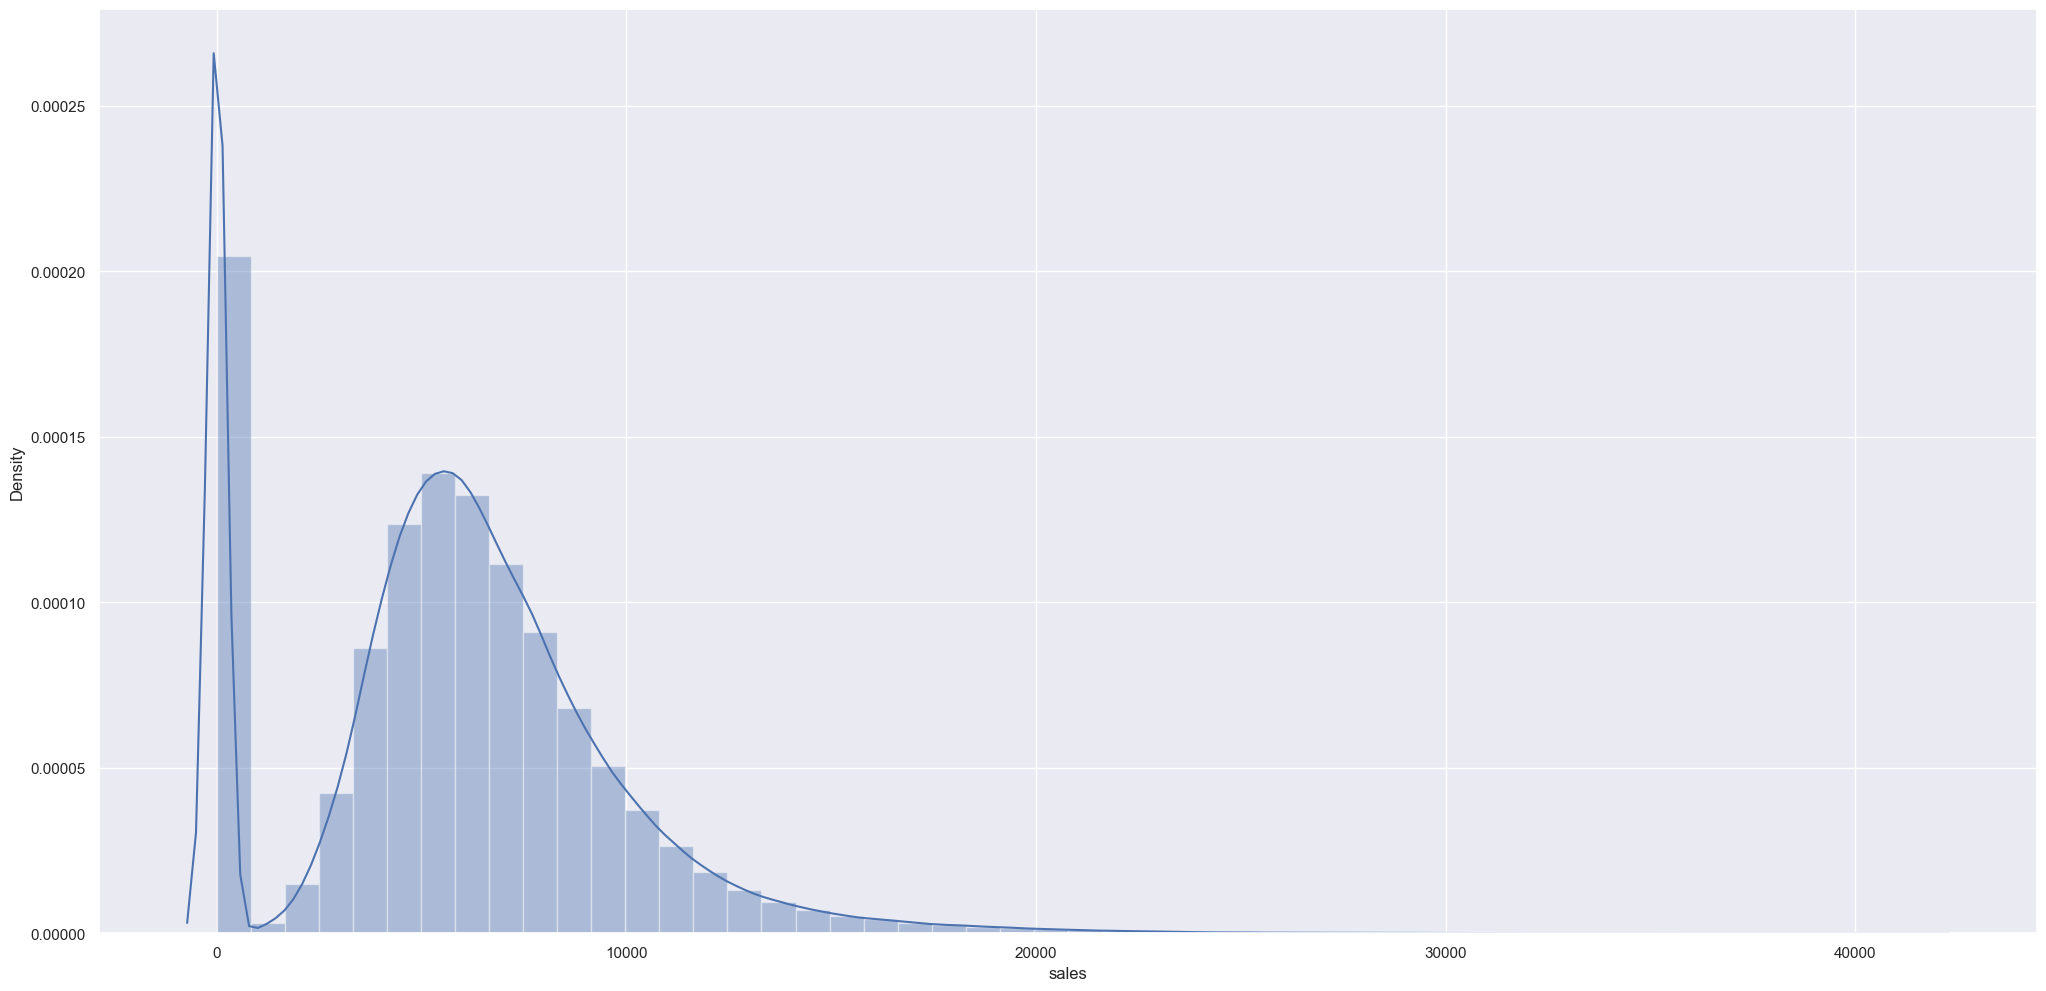

In [16]:
sns.distplot(df1['sales'])

### 1.7.2 Categorial Attributes

In [17]:
cat_attributes.apply( lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

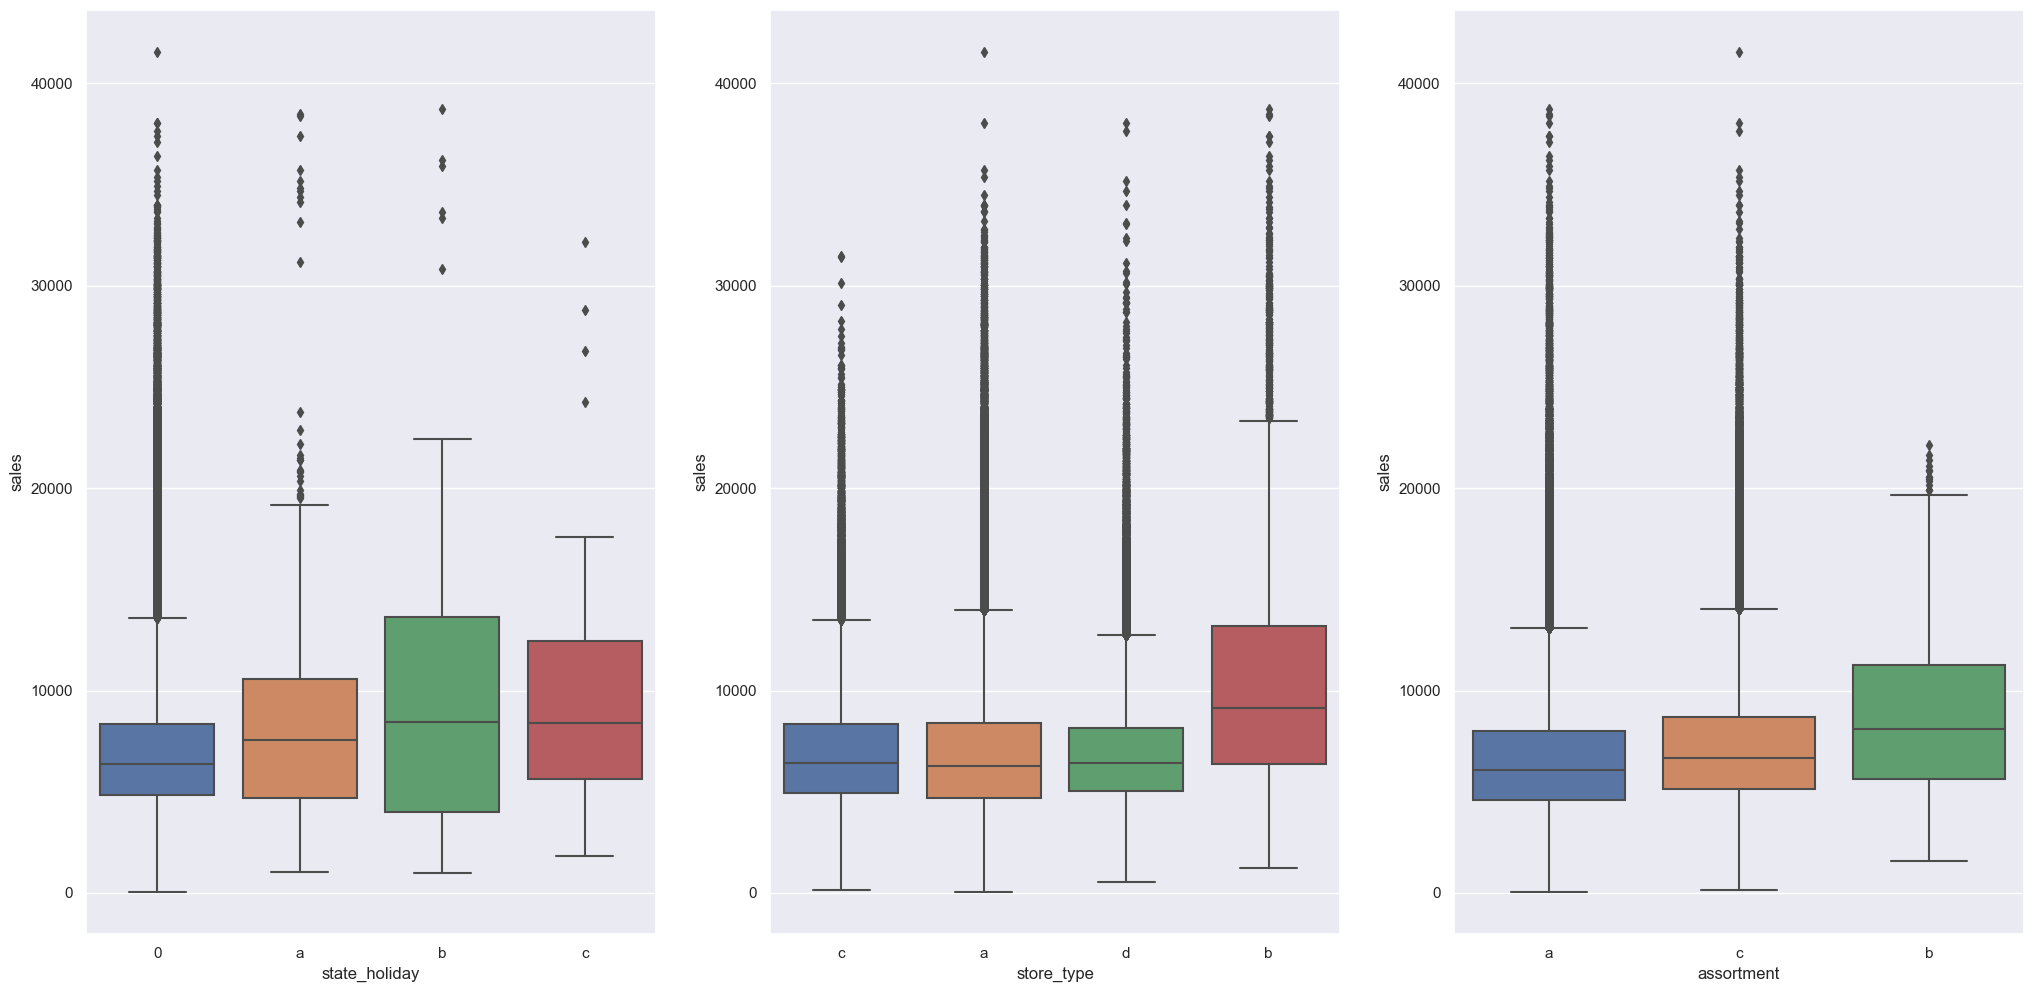

In [18]:
aux1 = df1[(df1['state_holiday'] !=0 ) & (df1['sales'] > 0)]

plt.subplot(1 , 3, 1)
sns.boxplot(x= 'state_holiday', y= 'sales' ,data= aux1 )

plt.subplot(1 , 3, 2)
sns.boxplot(x= 'store_type', y= 'sales' ,data= aux1 )

plt.subplot(1 , 3, 3)
sns.boxplot(x= 'assortment', y= 'sales' ,data= aux1 )

# 2.0 PASSO 02 - FEATURE ENGINEERING

In [19]:
df2 = df1.copy()

## 2.1 Mapa Mental de Hipoteses

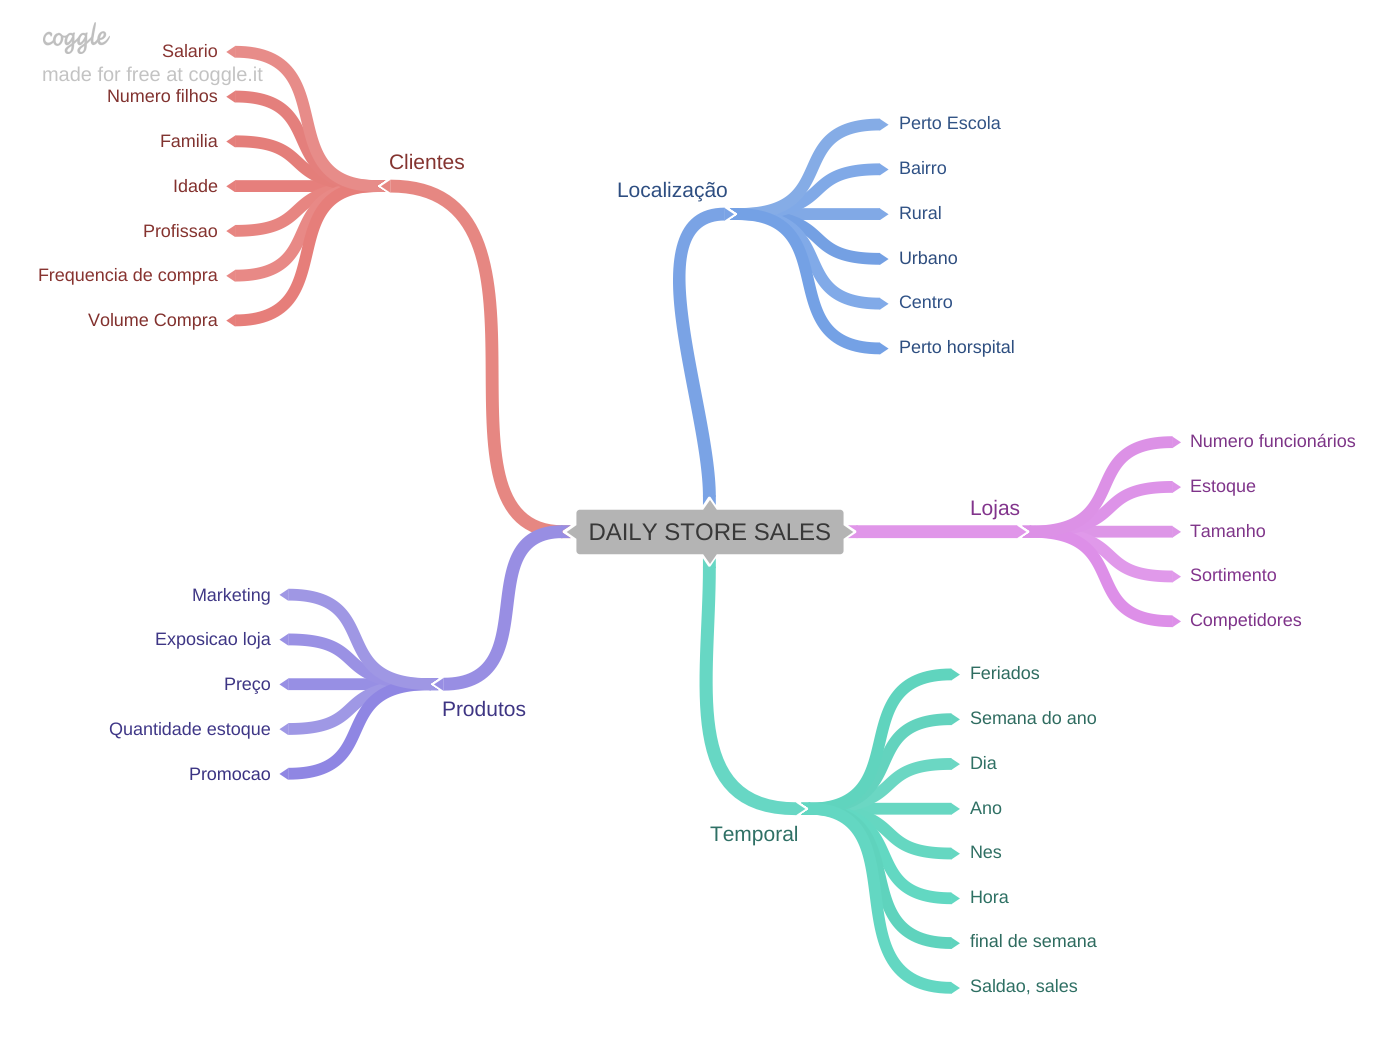

In [20]:
Image('C:/Users/Leonardo2/Documents/repos/DS_producao/img/Mind_Map_Hypoteses.png')

## 2.1 Criação de Hipoteses

### 2.1.1 Hipoteses Loja

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores a mais tempo deveriam vender mais.

### 2.1.2 Hipoteses Produto

**1.** Lojas que investem mais em marketing, deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preços menor deveriam vender mais.

**4.** Lojas como promoções mais agressivas( descontos maiores), deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveria vender mais

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.1.3 Hipoteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao londo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.2 Lista Final de Hipoteses

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores a mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveria vender mais

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao londo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3 Feature Engineering

In [21]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
#df2['week_of_year'] = df2['date'].dt.weekofyear
df2['week_of_year'] = df2['date'].dt.isocalendar().week.astype('int64')
# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W')

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis =1)
df2['competition_time_month'] = ( (df2['date'] - df2['competition_since']) / 30 ).apply(lambda x: x.days).astype( 'int64' )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)

df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta( days = 7))

df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'])/7 ). apply(lambda x: x.days).astype('int64')

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public holiday' if x == 'a' else 'Easter holiday' if x == 'b' else 'Christmas' if x == 'c' else 'regular_day')



# 3.0 PASSO 03 - FILTRAGEM DE VARIÁVEIS

In [22]:
df3 = df2.copy()

In [23]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.00,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.00,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.00,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.00,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.00,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0



## 3.1 Filtragem as linhas

In [24]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Selecao das Colunas

In [25]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [26]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 PASSO 04 - ANALISE EXPLORATORIA DOS DADOS

In [27]:
df4 = df3.copy()

## 4.1 Análise univariada

### 4.1.1. Response Variable

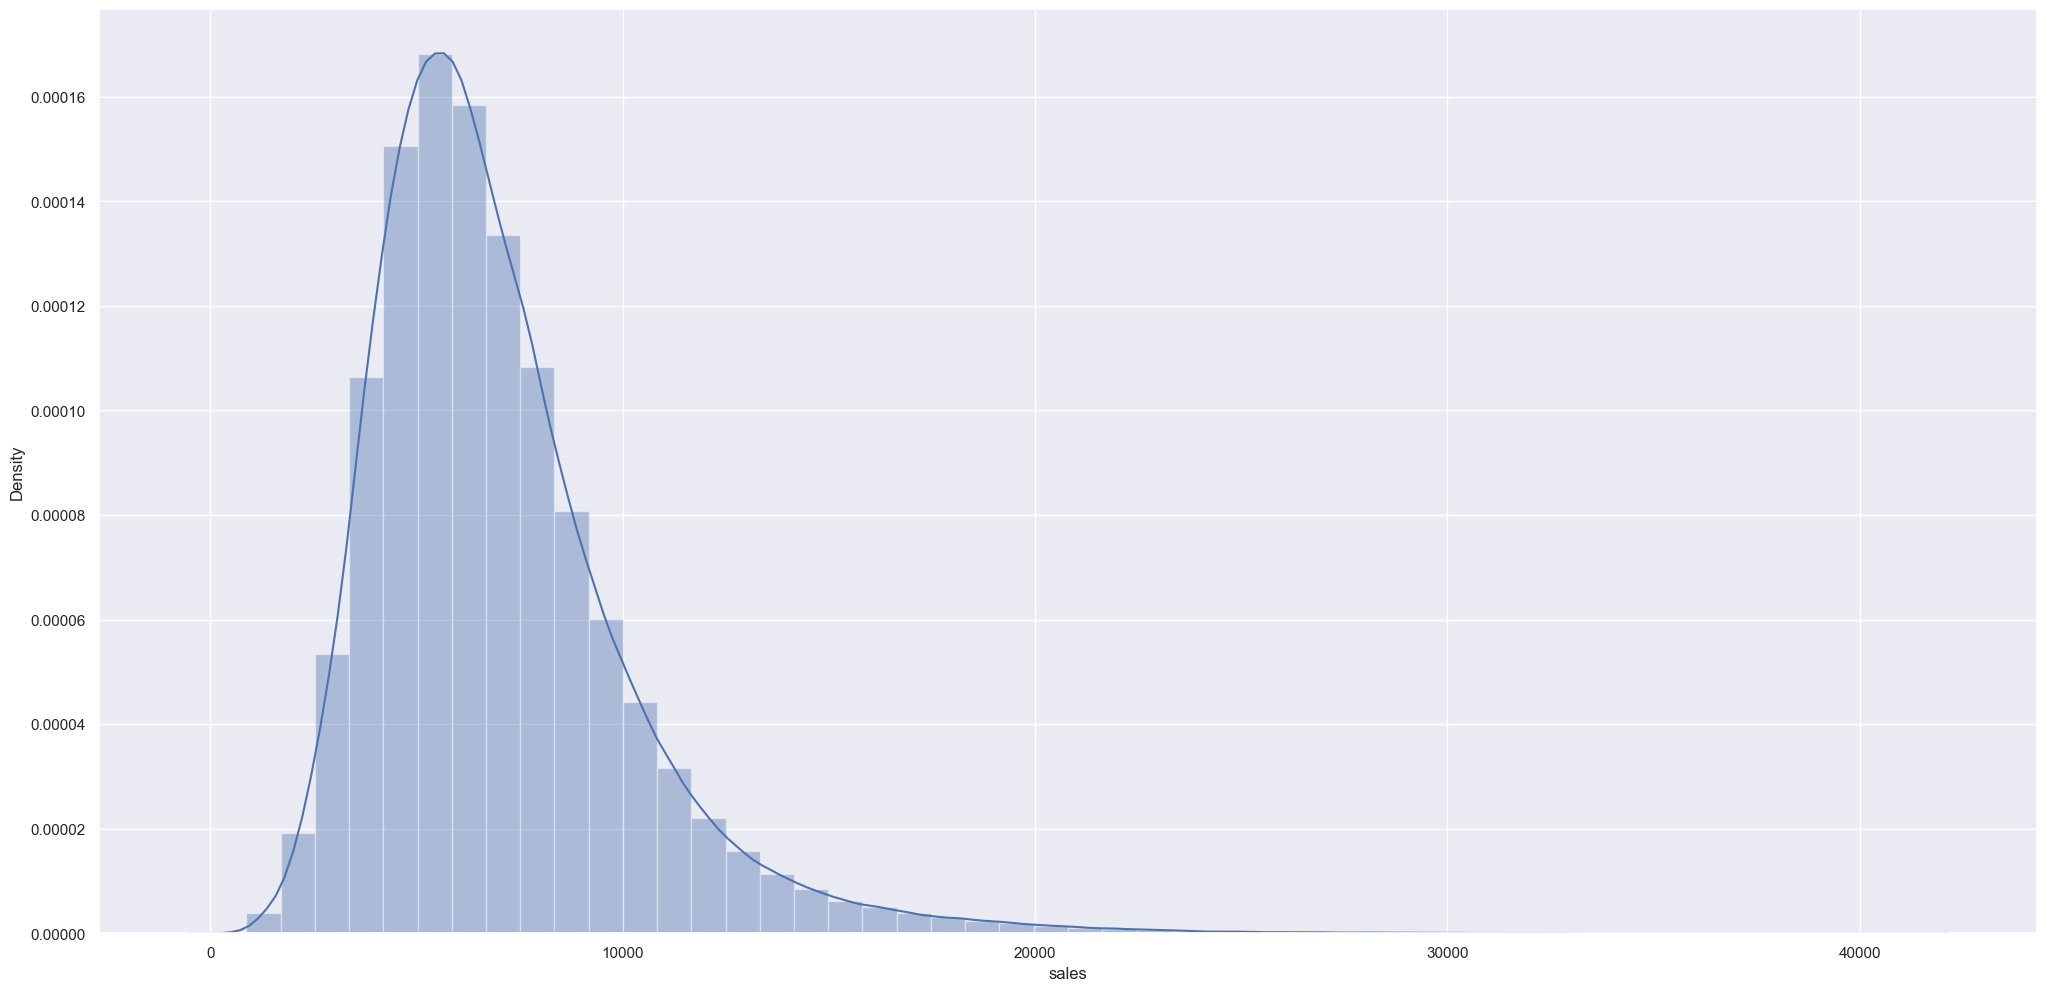

In [28]:
sns.distplot(df4['sales']);

### 4.1.2. Numerical Variable

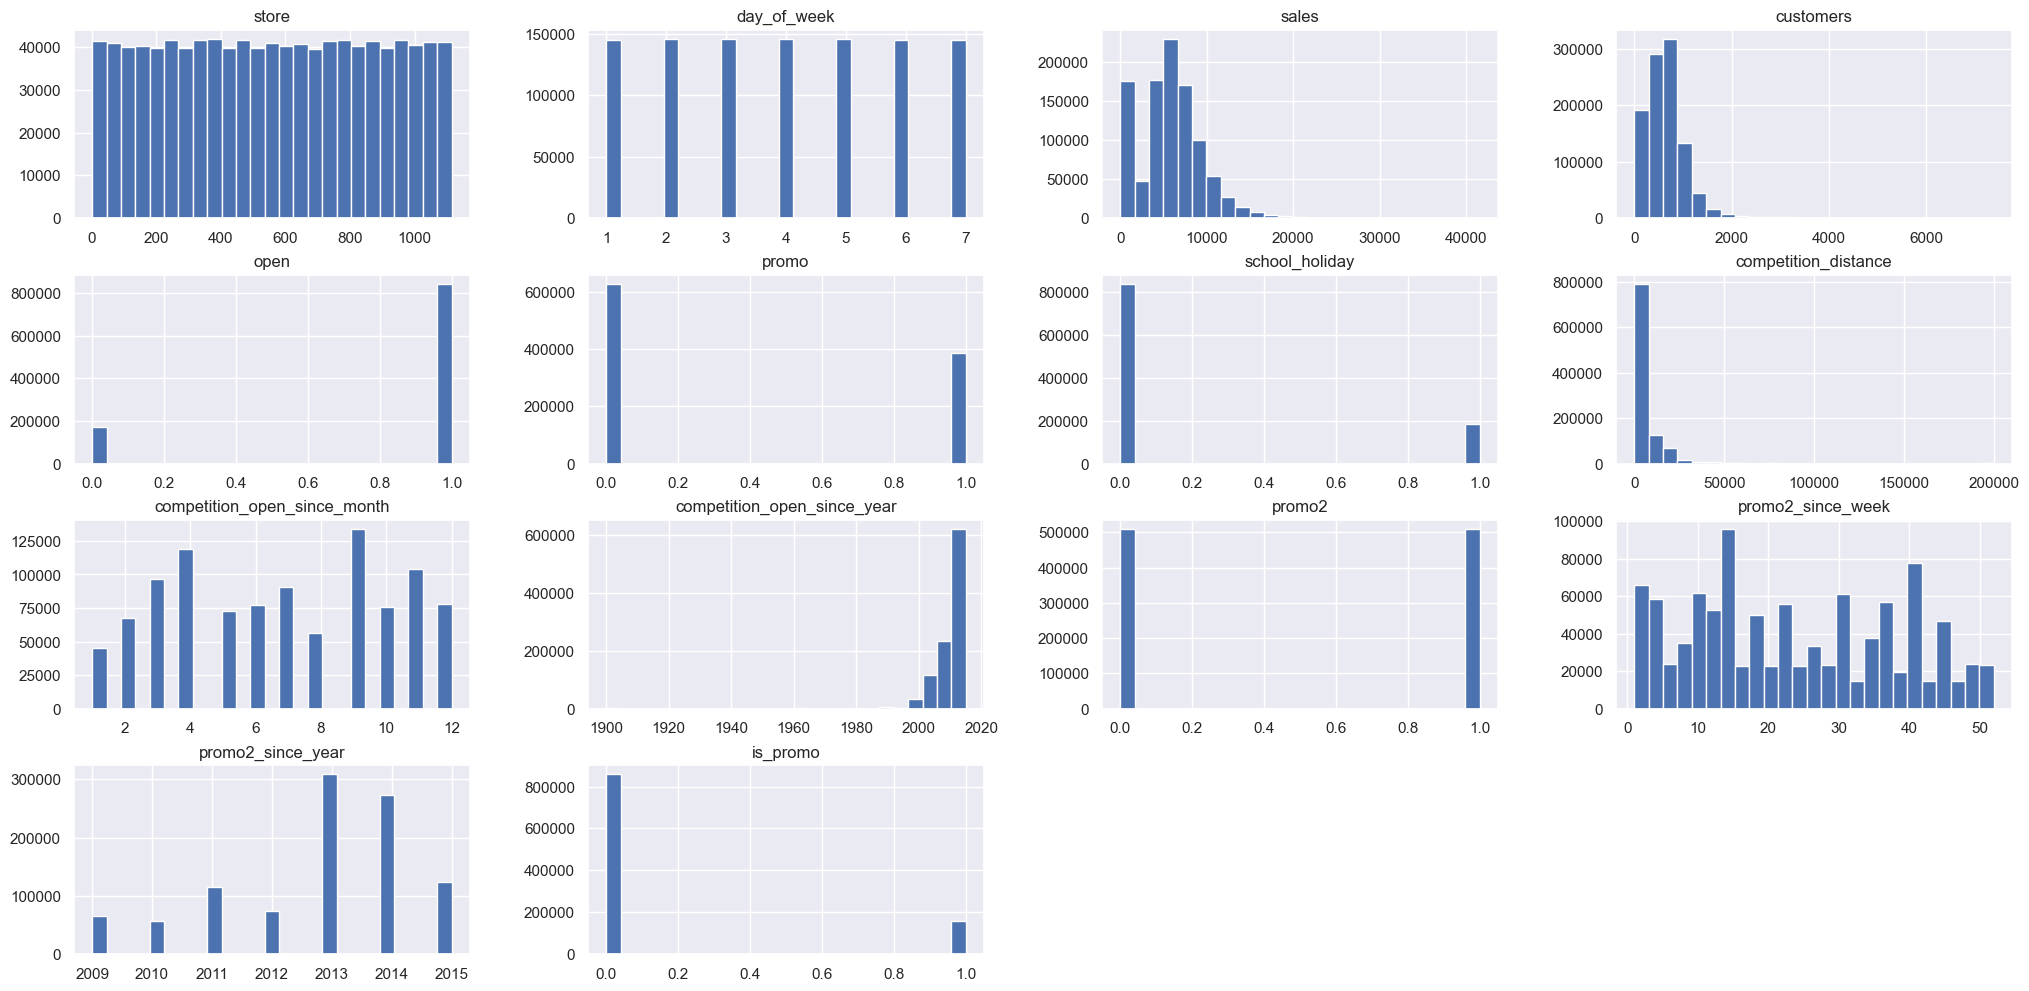

In [29]:
num_attributes.hist(bins=25);

### 4.1.3. Categorical Variable

<AxesSubplot:xlabel='sales', ylabel='Density'>

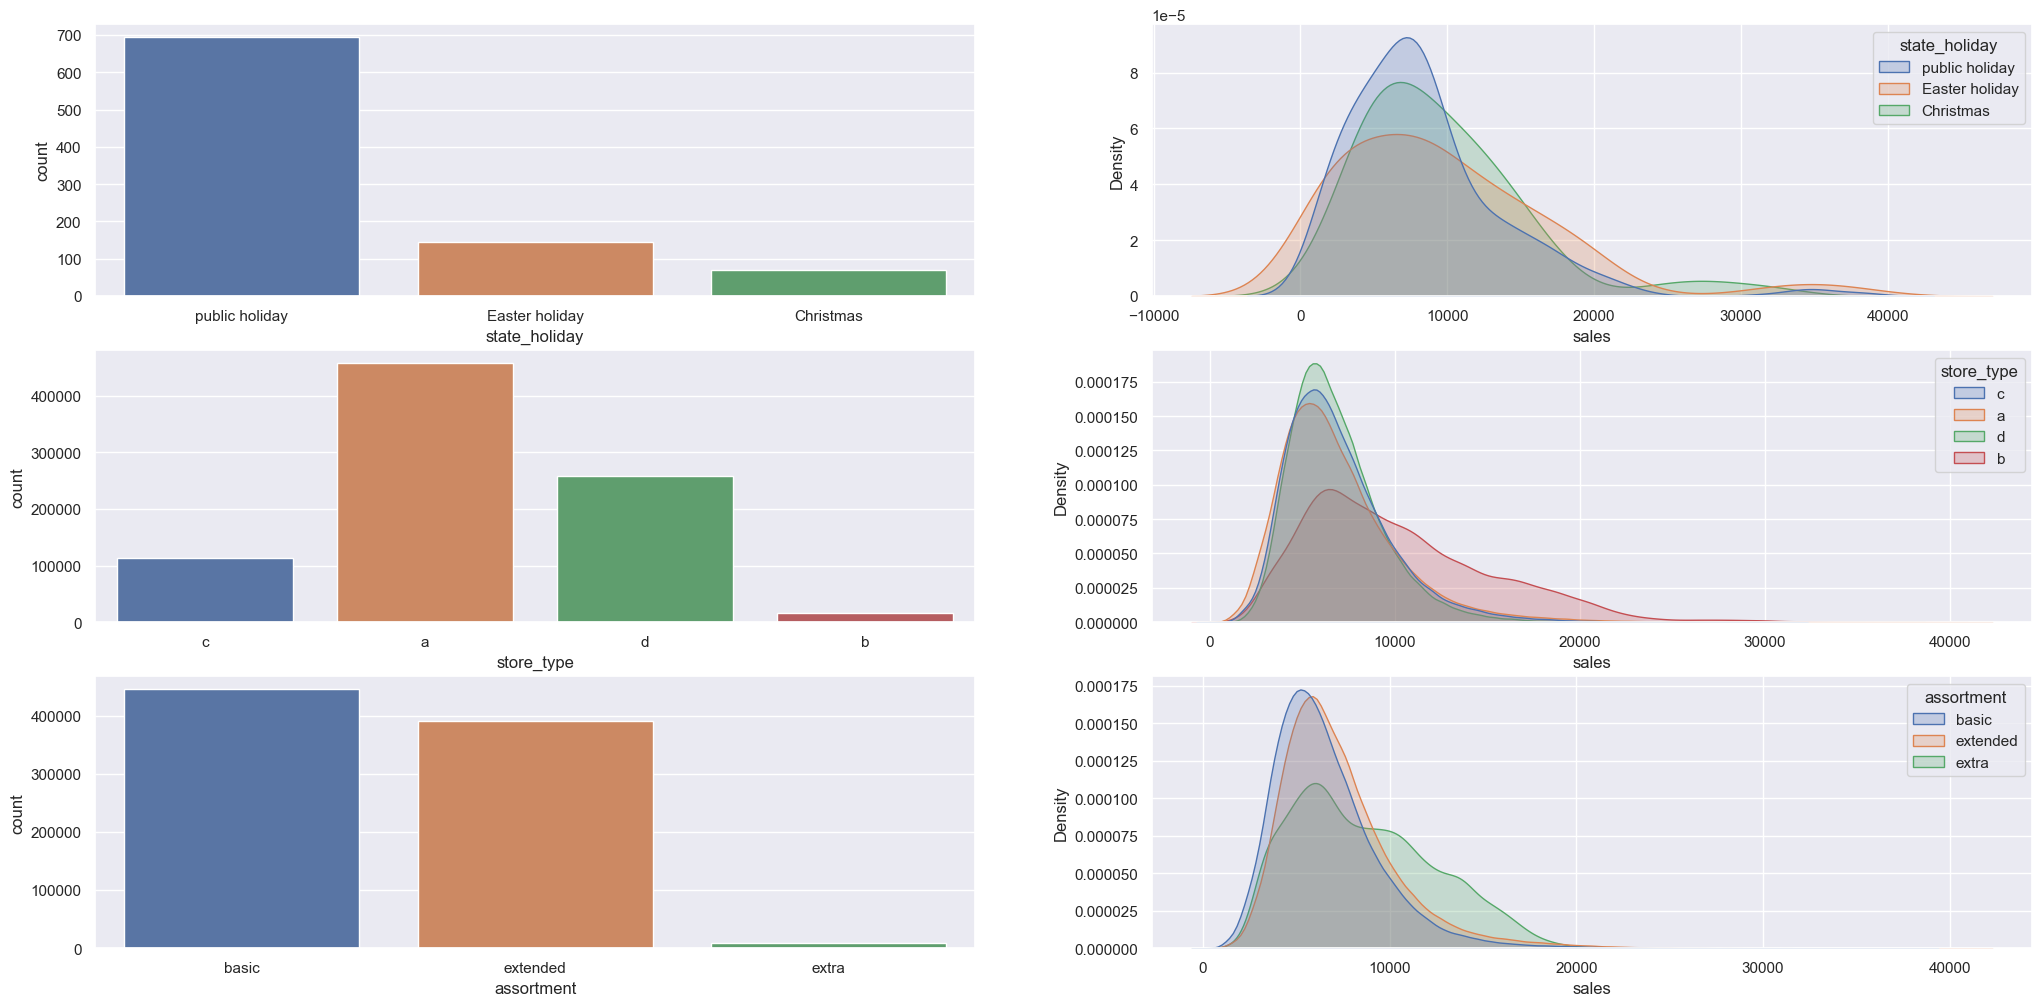

In [30]:
# state_holiday
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(data =a, x='state_holiday')

plt.subplot(3, 2, 2)

a = df4[df4['state_holiday'] != 'regular_day']
sns.kdeplot(data=a , x='sales', hue='state_holiday', fill=True, common_norm=False )

#sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True )
#sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True )
#sns.kdeplot( df4[df4['state_holiday'] == 'christimas_holiday']['sales'], label='christimas_holiday', shade=True )

# store_type
plt.subplot( 3, 2, 3 )
sns.countplot( x=df4['store_type'] )

plt.subplot( 3, 2, 4 )
sns.kdeplot(data=df4 , x='sales', hue='store_type',  fill=True, common_norm=False )

# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( x=df4['assortment'] )

plt.subplot( 3, 2, 6 )
sns.kdeplot(data=df4 , x='sales', hue='assortment', fill=True, common_norm=False )


## 4.2 Análise bivariada

### **H1.** Lojas com maior sortimentos deveriam vender mais.
**FALSA** Lojas com MAIOR SORTMENTO VENDEM MENOS


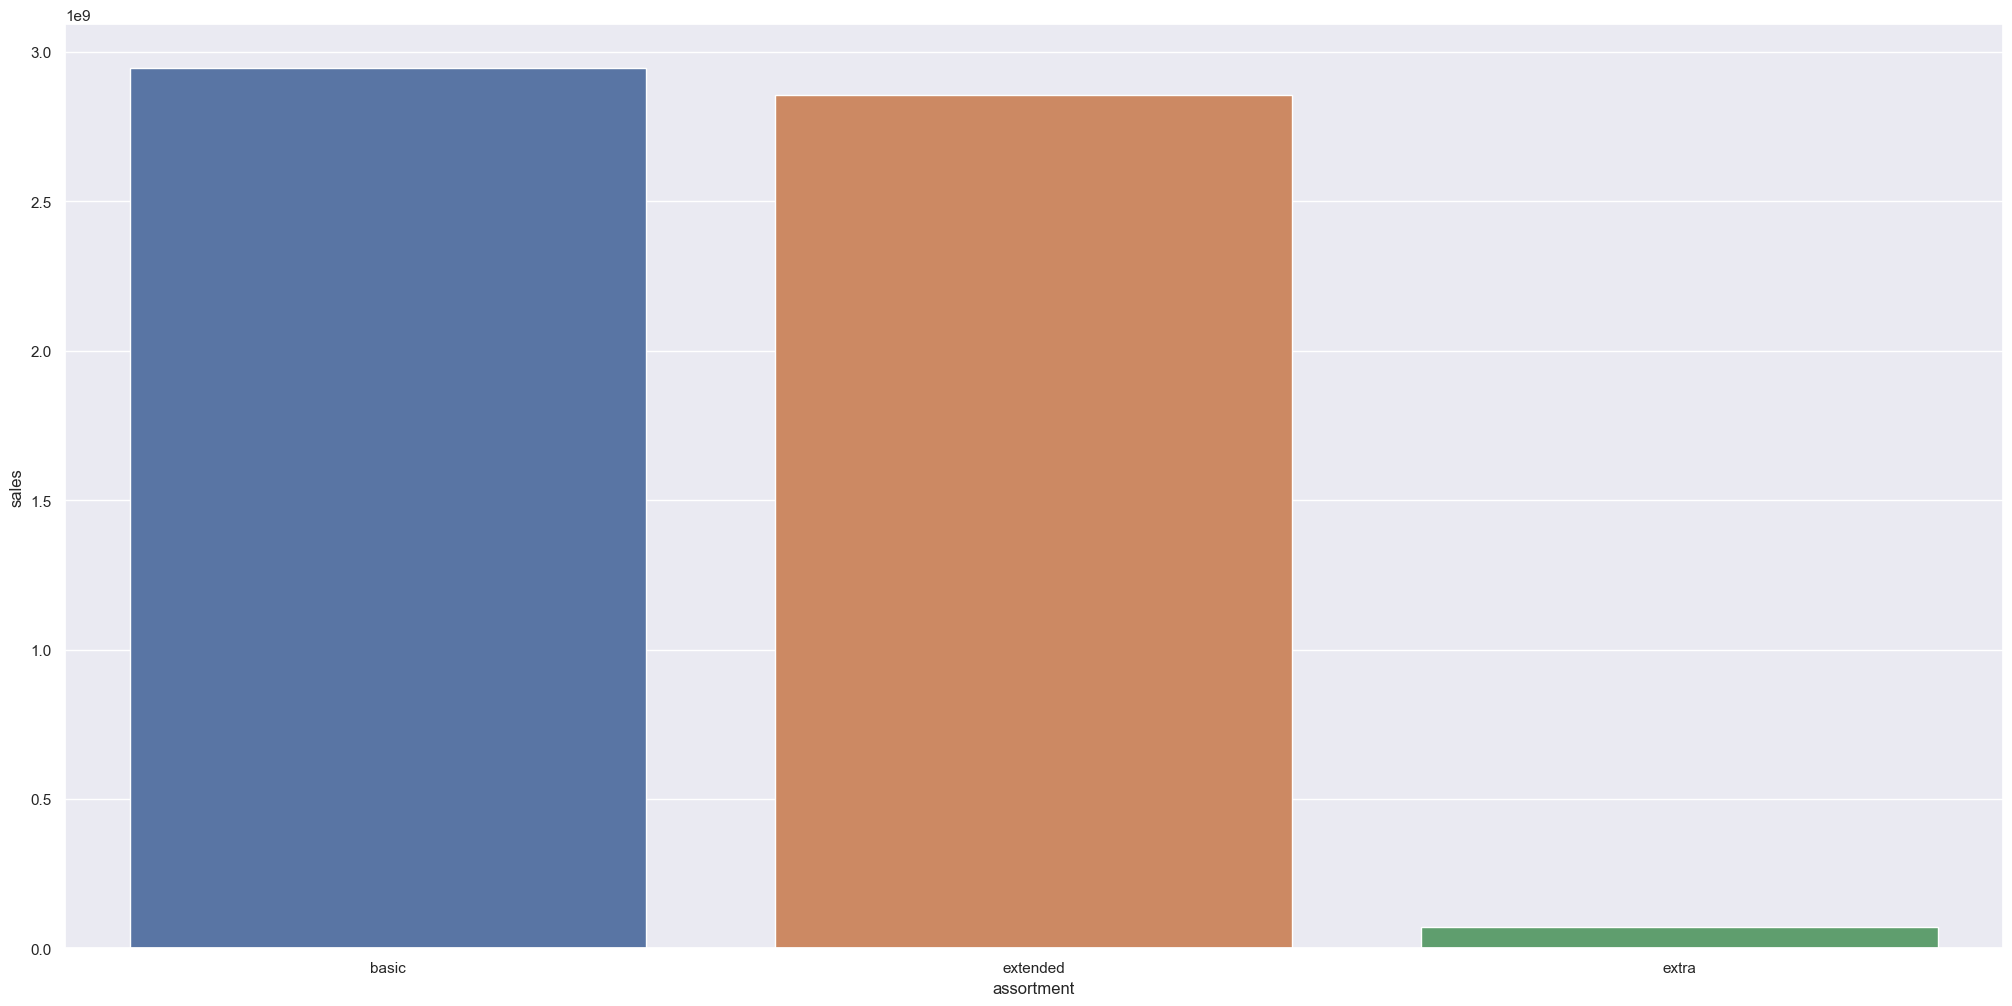

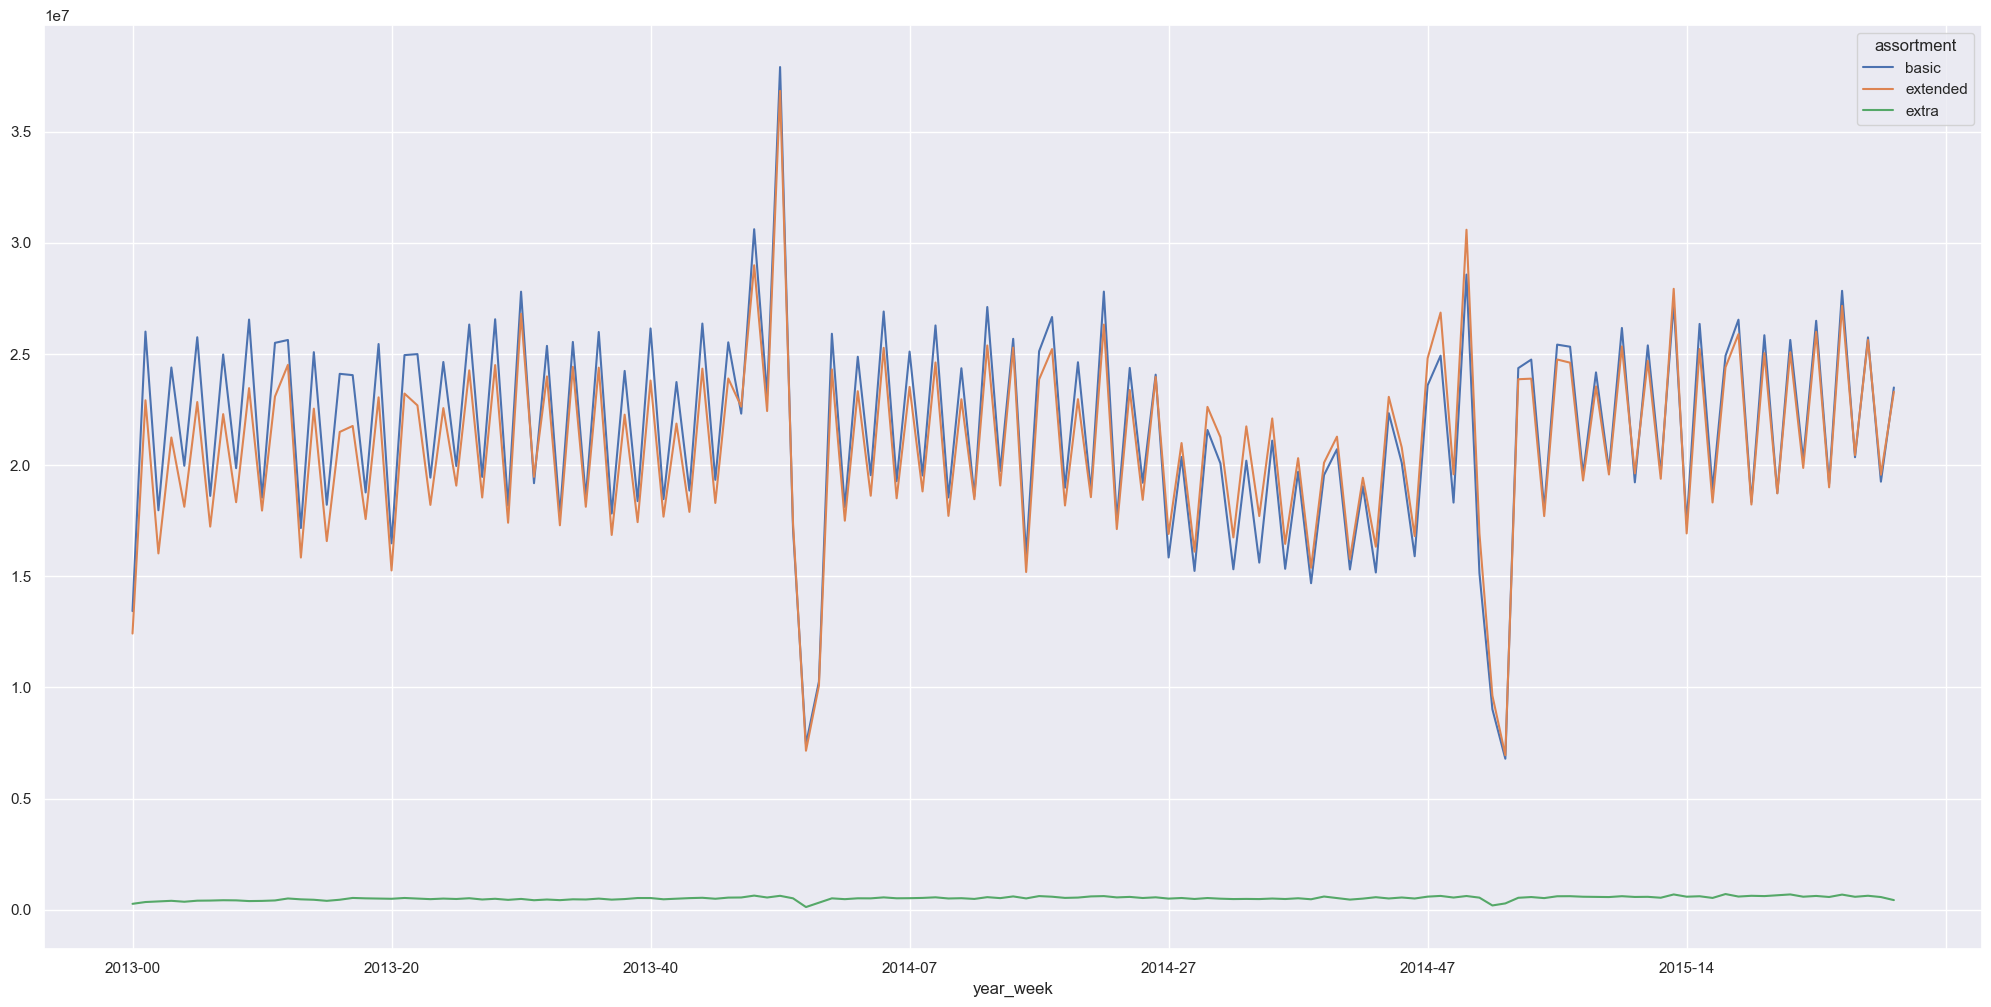

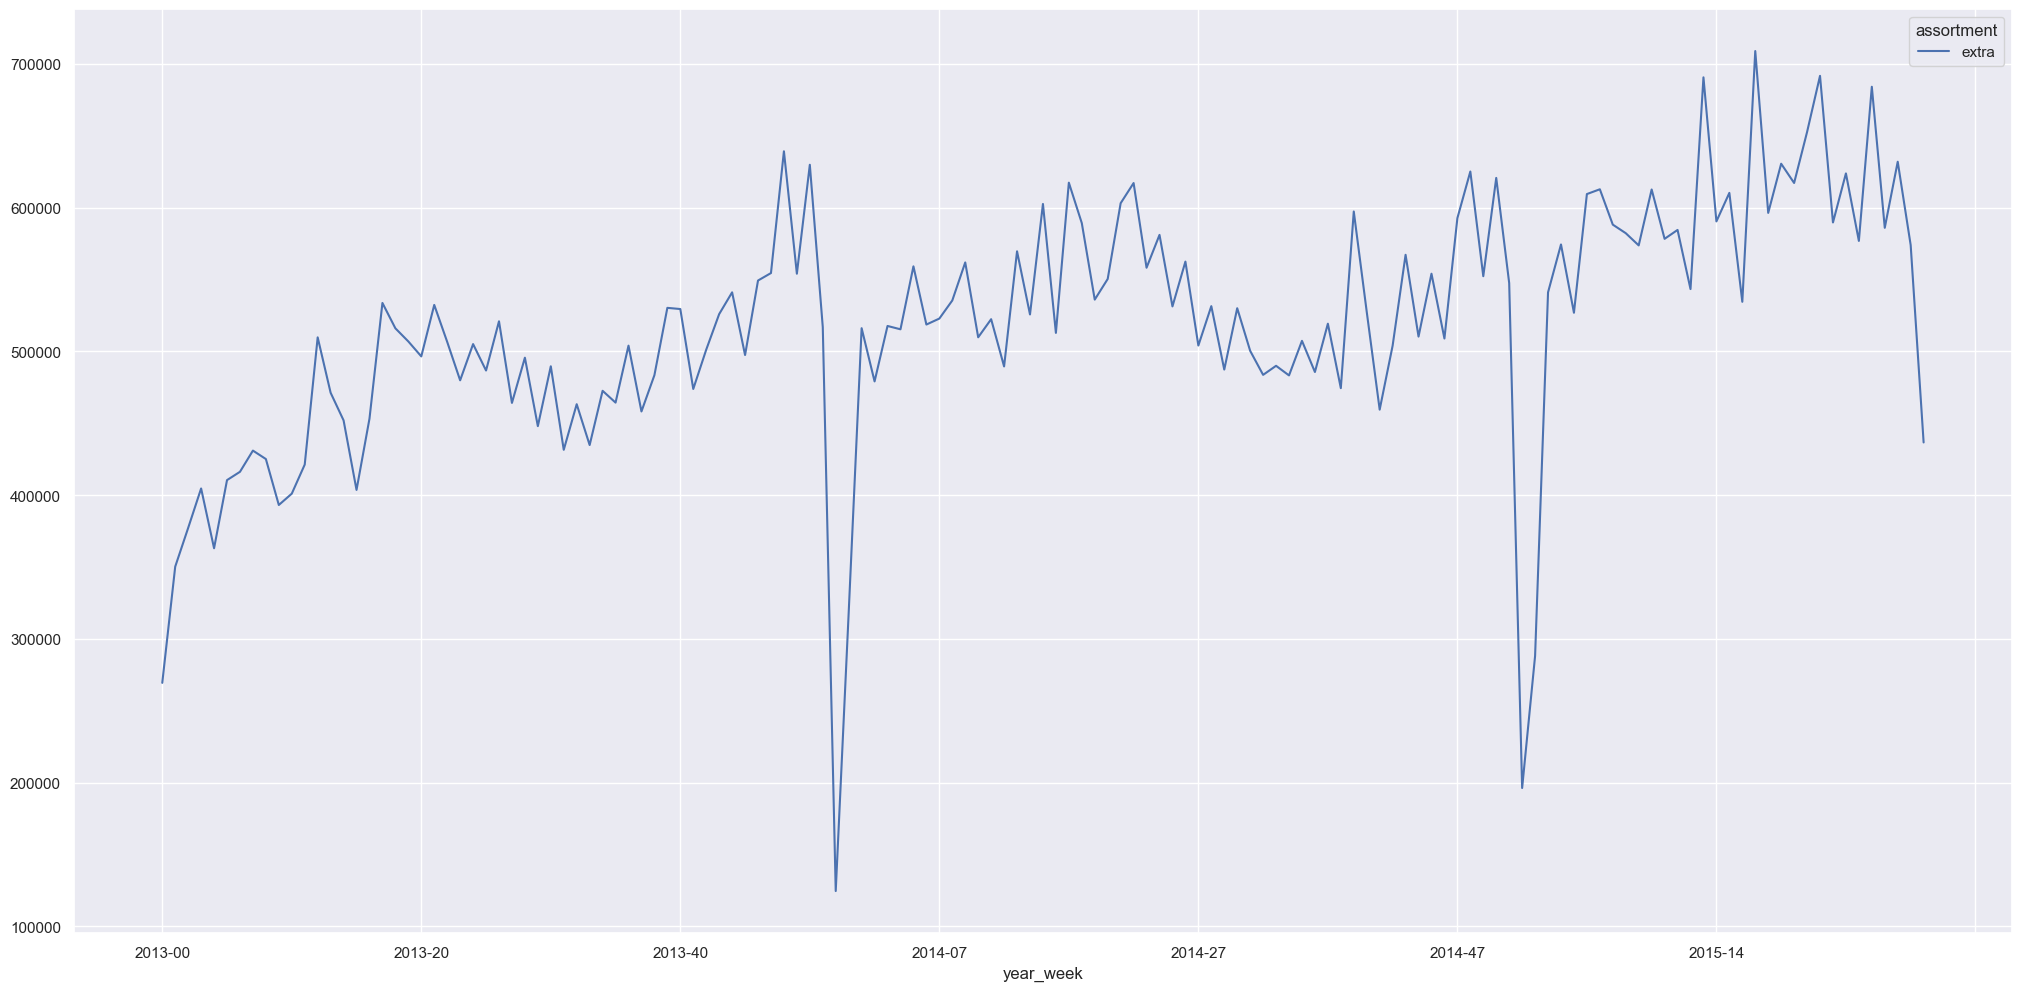

In [31]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x = 'assortment', y='sales', data=aux1);

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot();

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot();

### **H2.** Lojas com competidores mais próximos deveriam vender menos.
**Falsa** Lojas com competidores mais próximos vendem mais


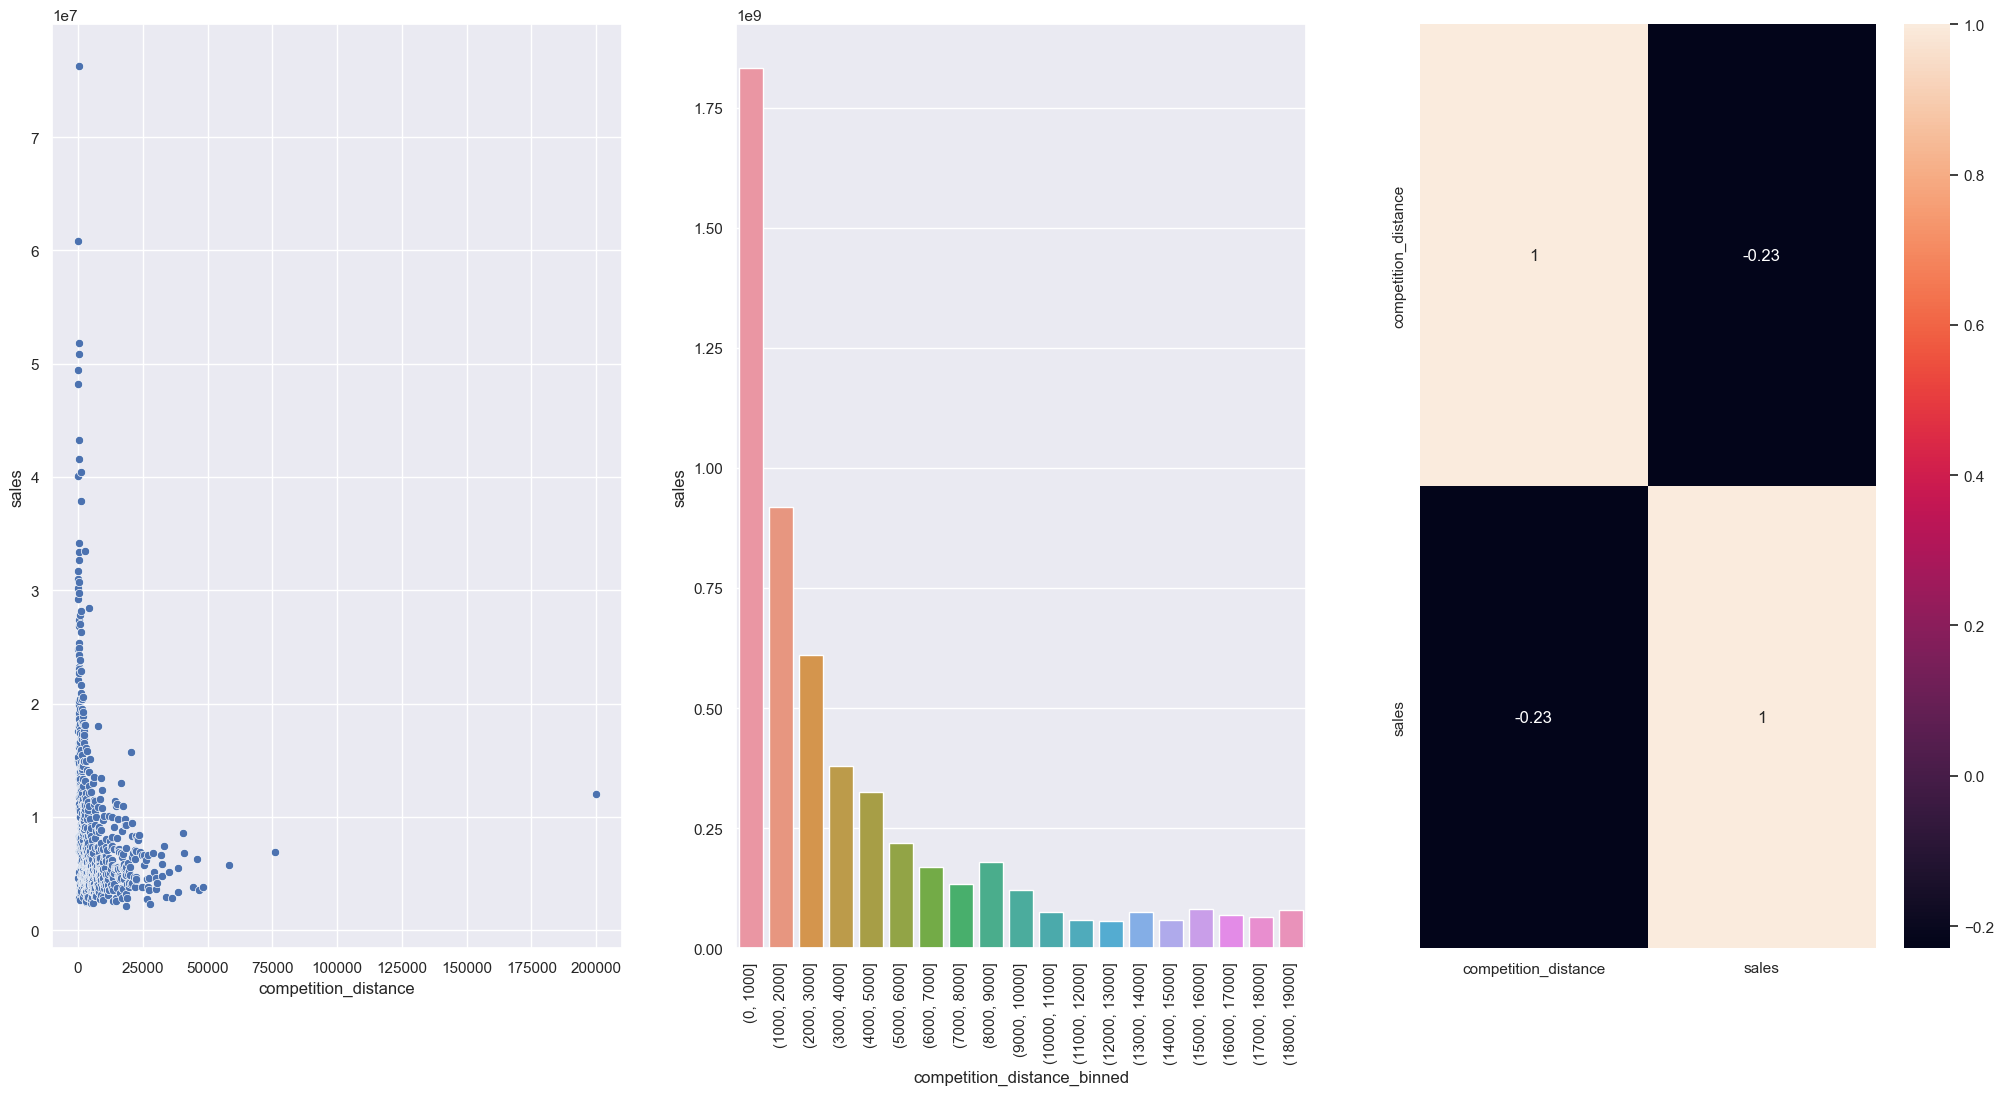

In [32]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

plt.subplot( 1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1);

plt.subplot( 1, 3, 2)
bins = list(np.arange( 0, 20000, 1000) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90)

plt.subplot( 1, 3, 3)
x = sns.heatmap(aux1.corr(method='pearson'), annot=True);


### **H3.** Lojas com competidores a mais tempo deveriam vender mais.
**Falsa** Lojas com competidores a mais tempo vendem menos

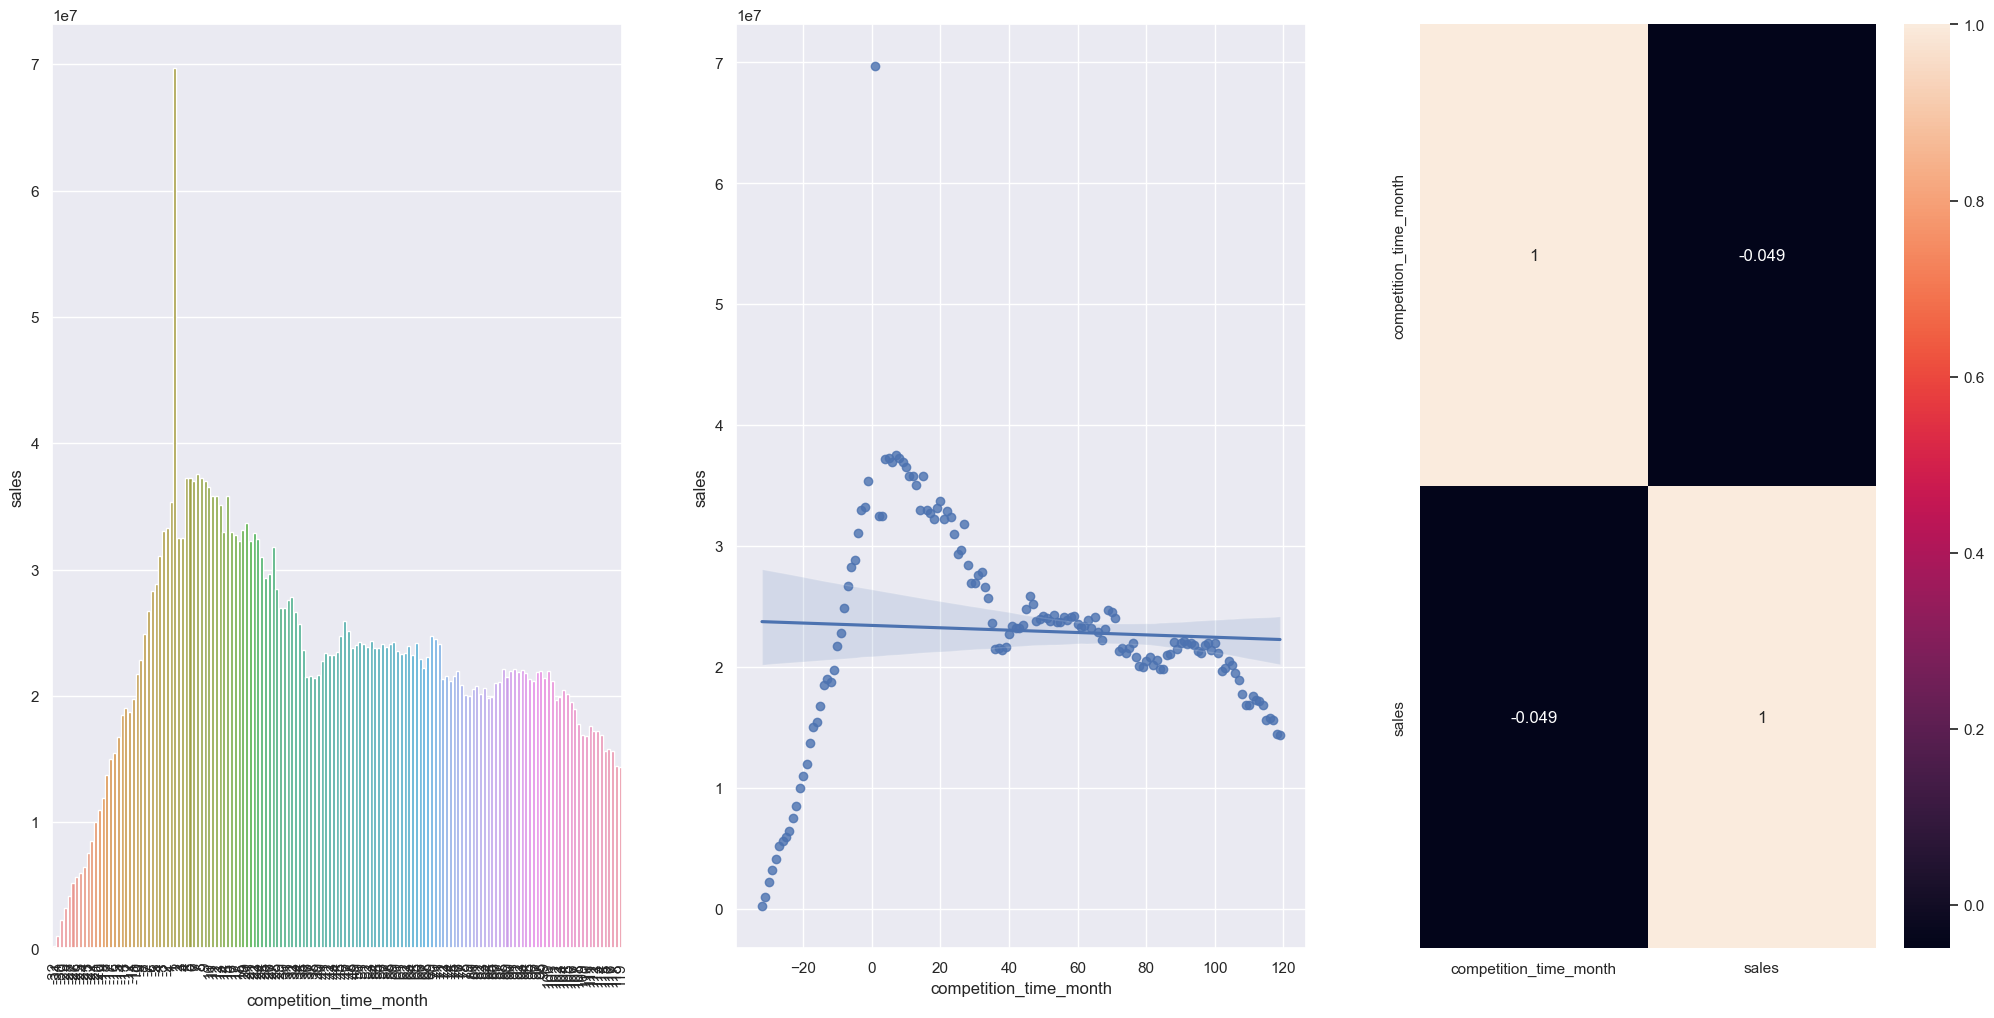

In [33]:
plt.subplot(1,3,1)
aux1 = df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales',data=aux2);
plt.xticks(rotation=90);

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month', y='sales',data=aux2);

plt.subplot(1,3,3)
x = sns.heatmap(aux2.corr(method='pearson'), annot=True);

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSA** Lojas com promocoes ativas por mais tempo vendem menos depois de um certo tempo de promocao


In [34]:
df4.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.00,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.00,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.00,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.00,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.00,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


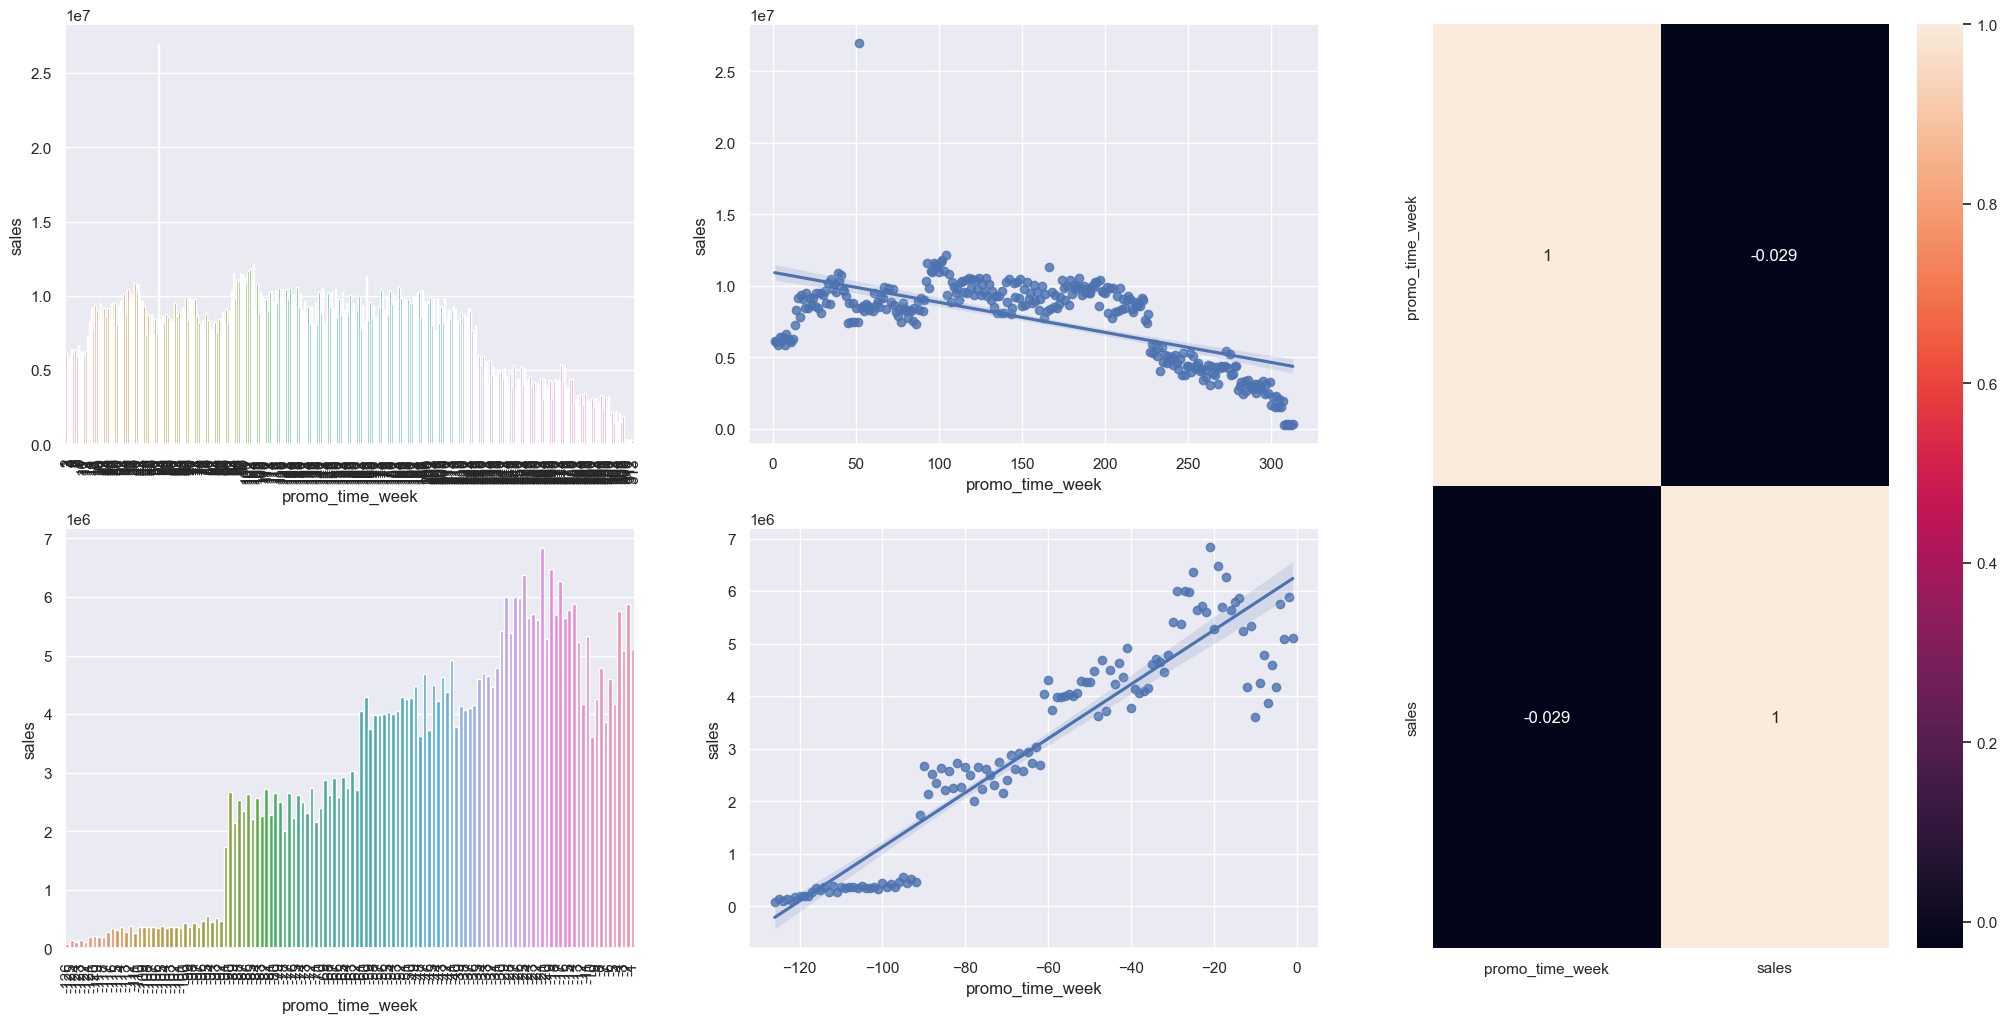

In [35]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = plt.GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0 ] #promo extendido
sns.barplot(x='promo_time_week', y='sales',data=aux2);
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales',data=aux2);

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0 ] #promo regular
sns.barplot(x='promo_time_week', y='sales',data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales',data=aux3);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot = True);

### <s>**H5.** Lojas com mais dias de promoção deveria vender mais.</s>



### H6. Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA** Lojas com mais promocoes consecutivas vendem menos

In [36]:
df4[['promo','promo2','sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


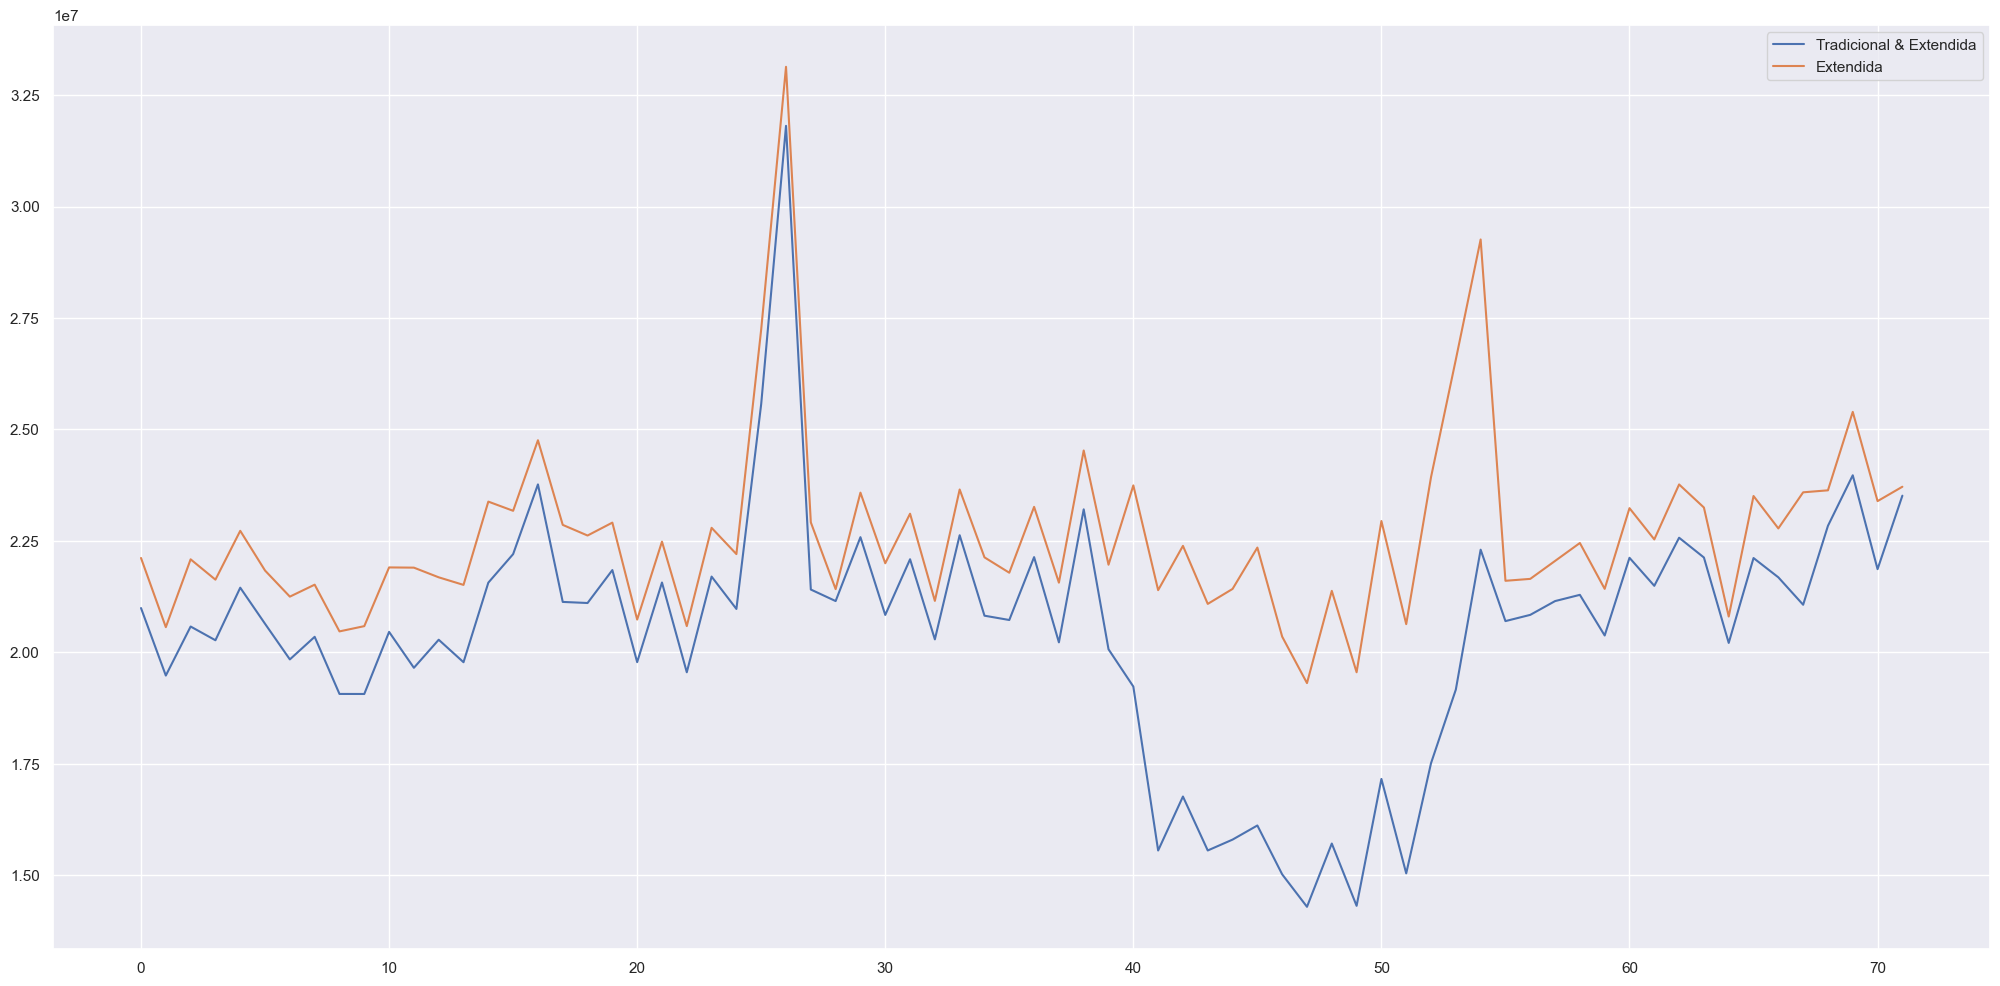

In [37]:
aux1 = df4[(df4['promo'] == 1 ) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot();

aux2 = df4[(df4['promo'] == 1 ) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax);

ax.legend(labels=['Tradicional & Extendida', 'Extendida']);

### **H7.** Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSA** Lojas Abertas durante o feriado do Natal vendem menos

In [38]:
df4.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.00,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.00,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.00,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.00,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.00,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


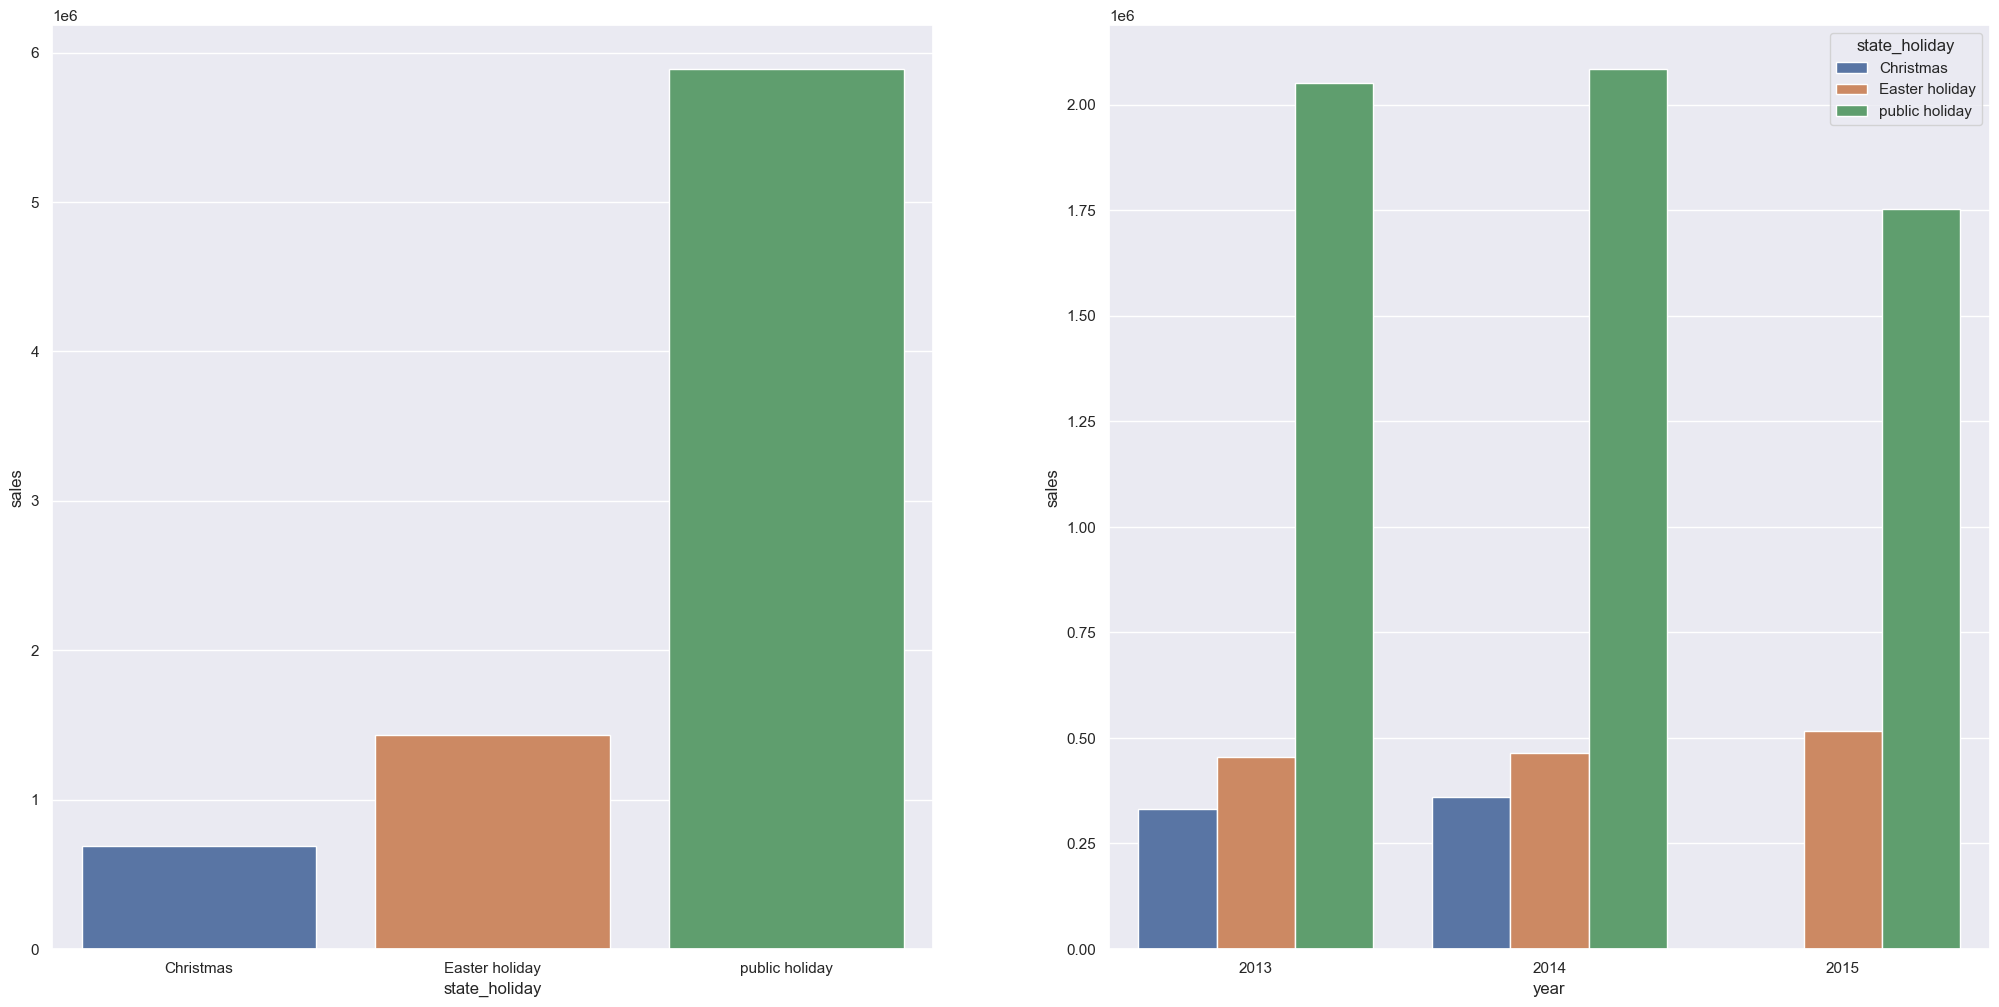

In [39]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1,2,1)
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1);

plt.subplot(1,2,2)
aux2 = aux[['year','state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);


### **H8.** Lojas deveriam vender mais ao londo dos anos.
**FALSA** Lojas vendem menos ao longo dos anos

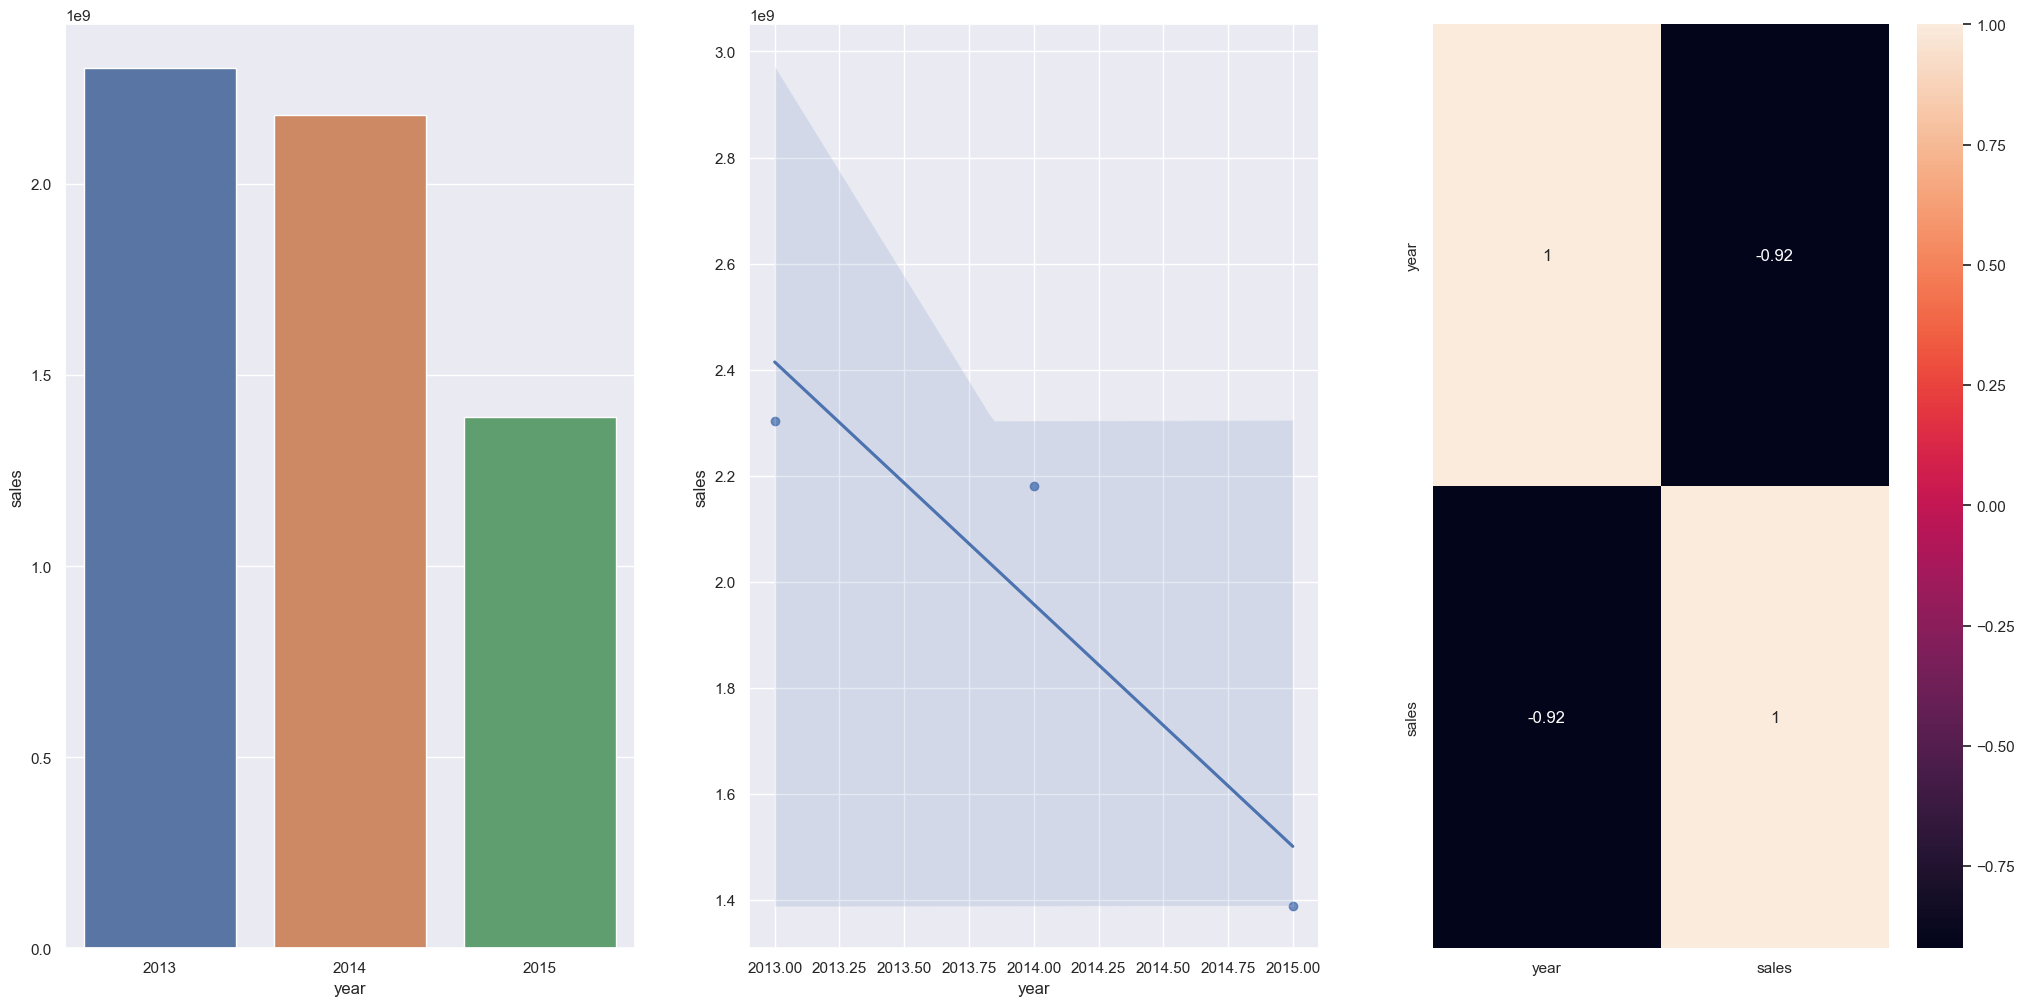

In [40]:
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **9.** Lojas deveriam vender mais no segundo semestre do ano.
**FALSA** As lojas vendem menos no segundo semestre do ano

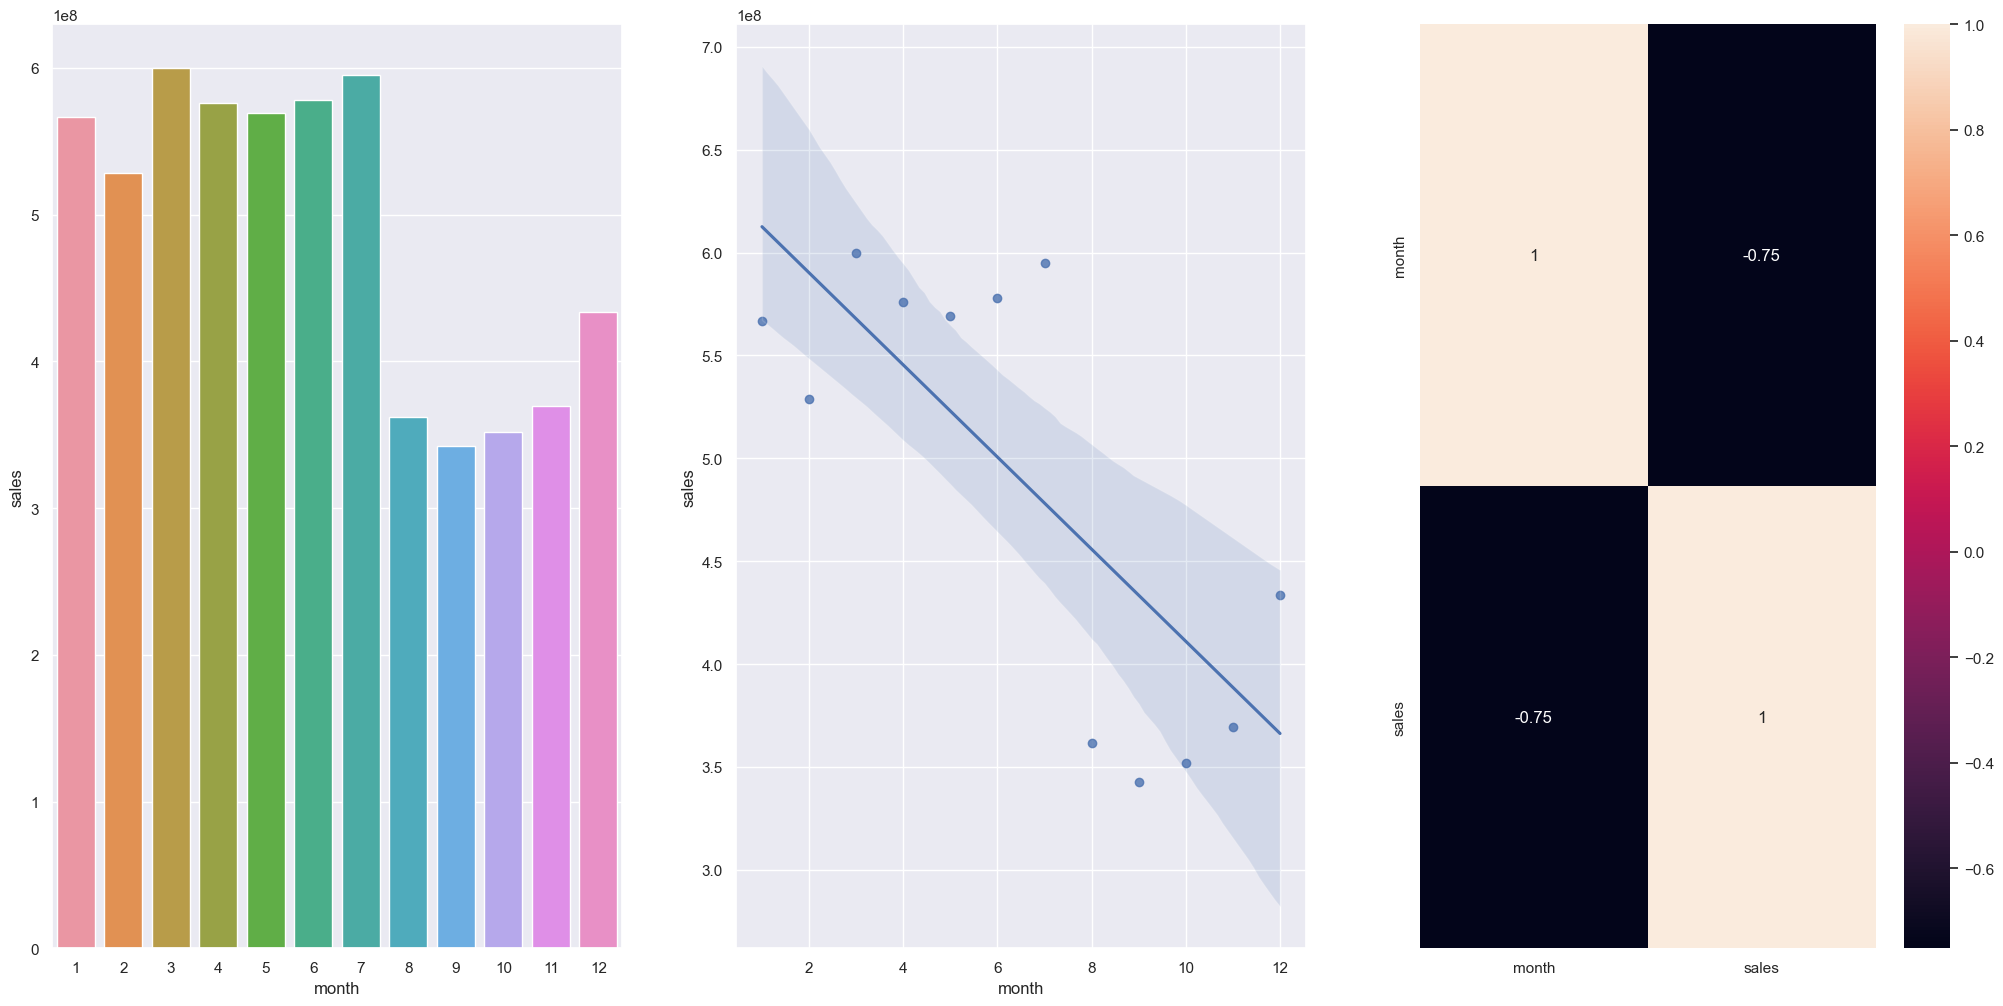

In [41]:
aux1 = df4[['month','sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **10.** Lojas deveriam mais depois do dia 10 de cada mês.
**VERDADEIRA** Lojas vendem mais depois do dia 10 de cada mês

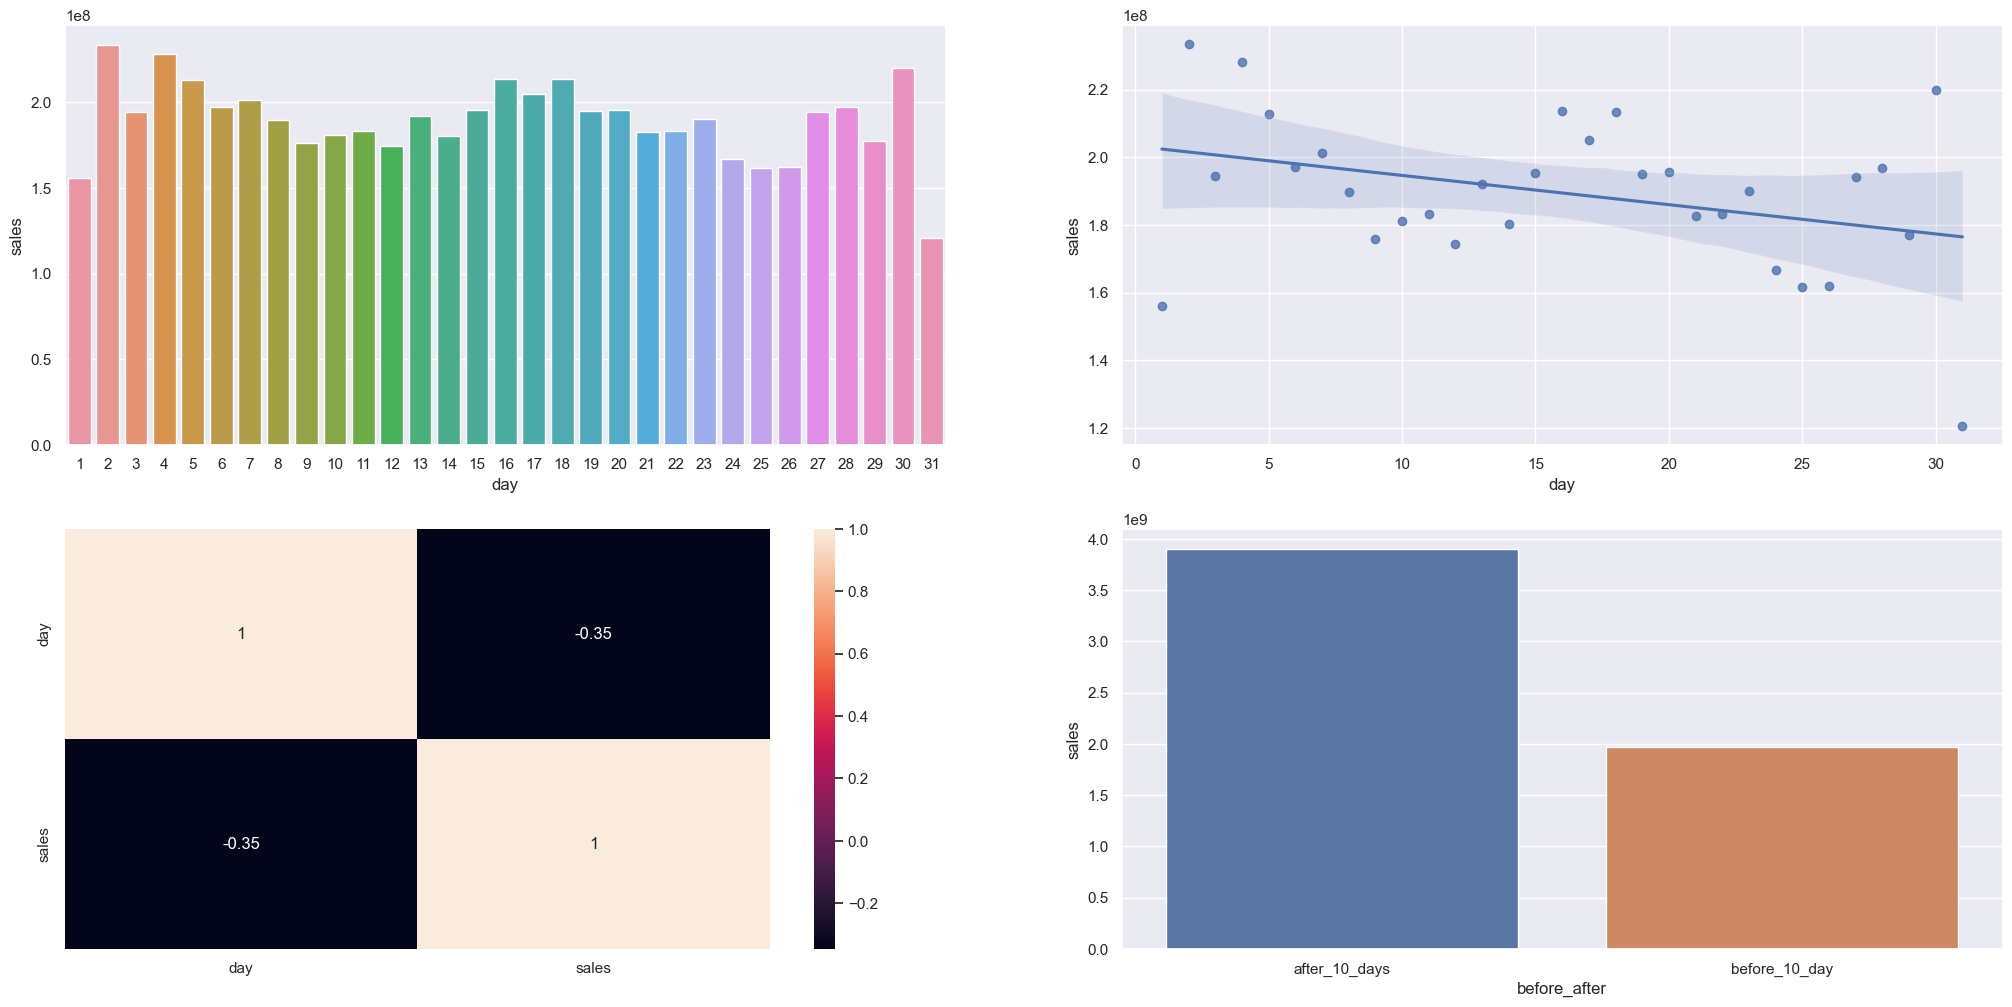

In [42]:
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);


aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_day' if x <=10 else "after_10_days" )
aux2 = aux1[['before_after','sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x='before_after', y='sales', data=aux2);

### **11.** Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA** Lojas vendem menos nos finais de semana

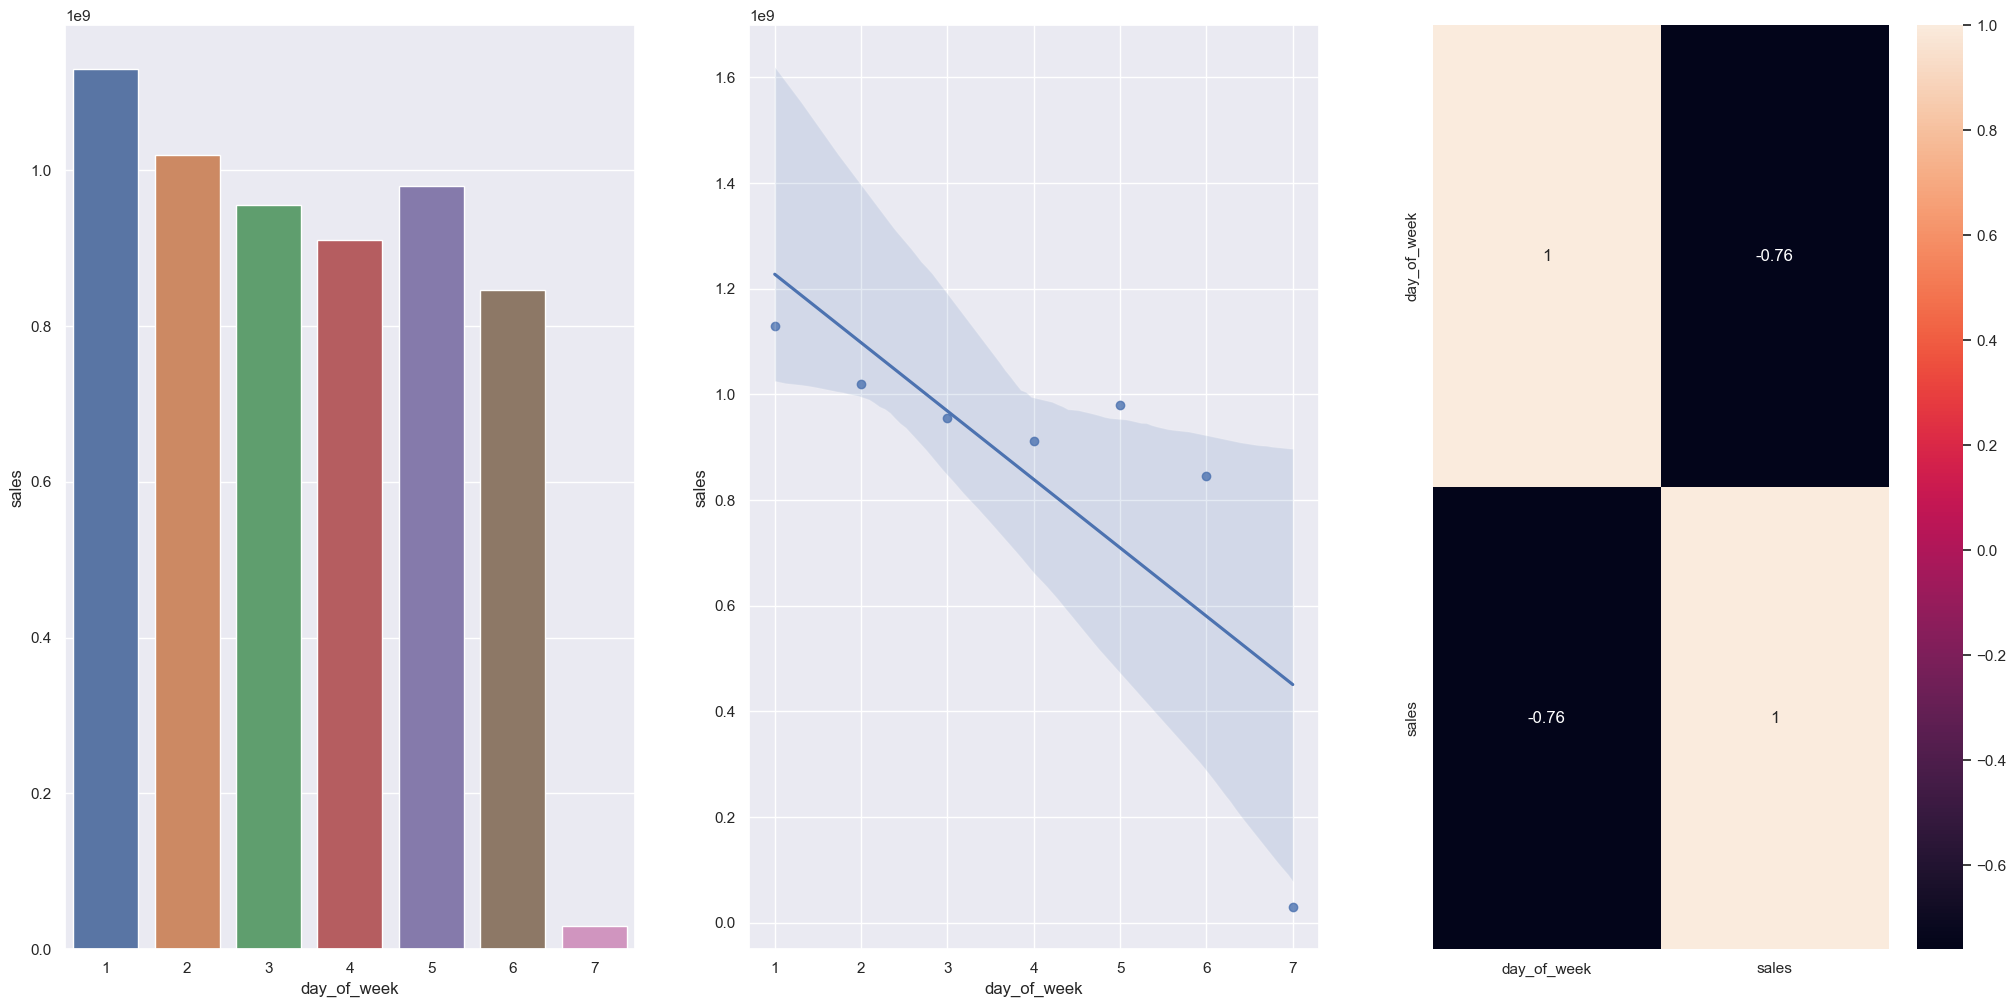

In [43]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **12.** Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRA** Lojas vendem menos durante os feriados escolares, exceto os meses de julho e agosto

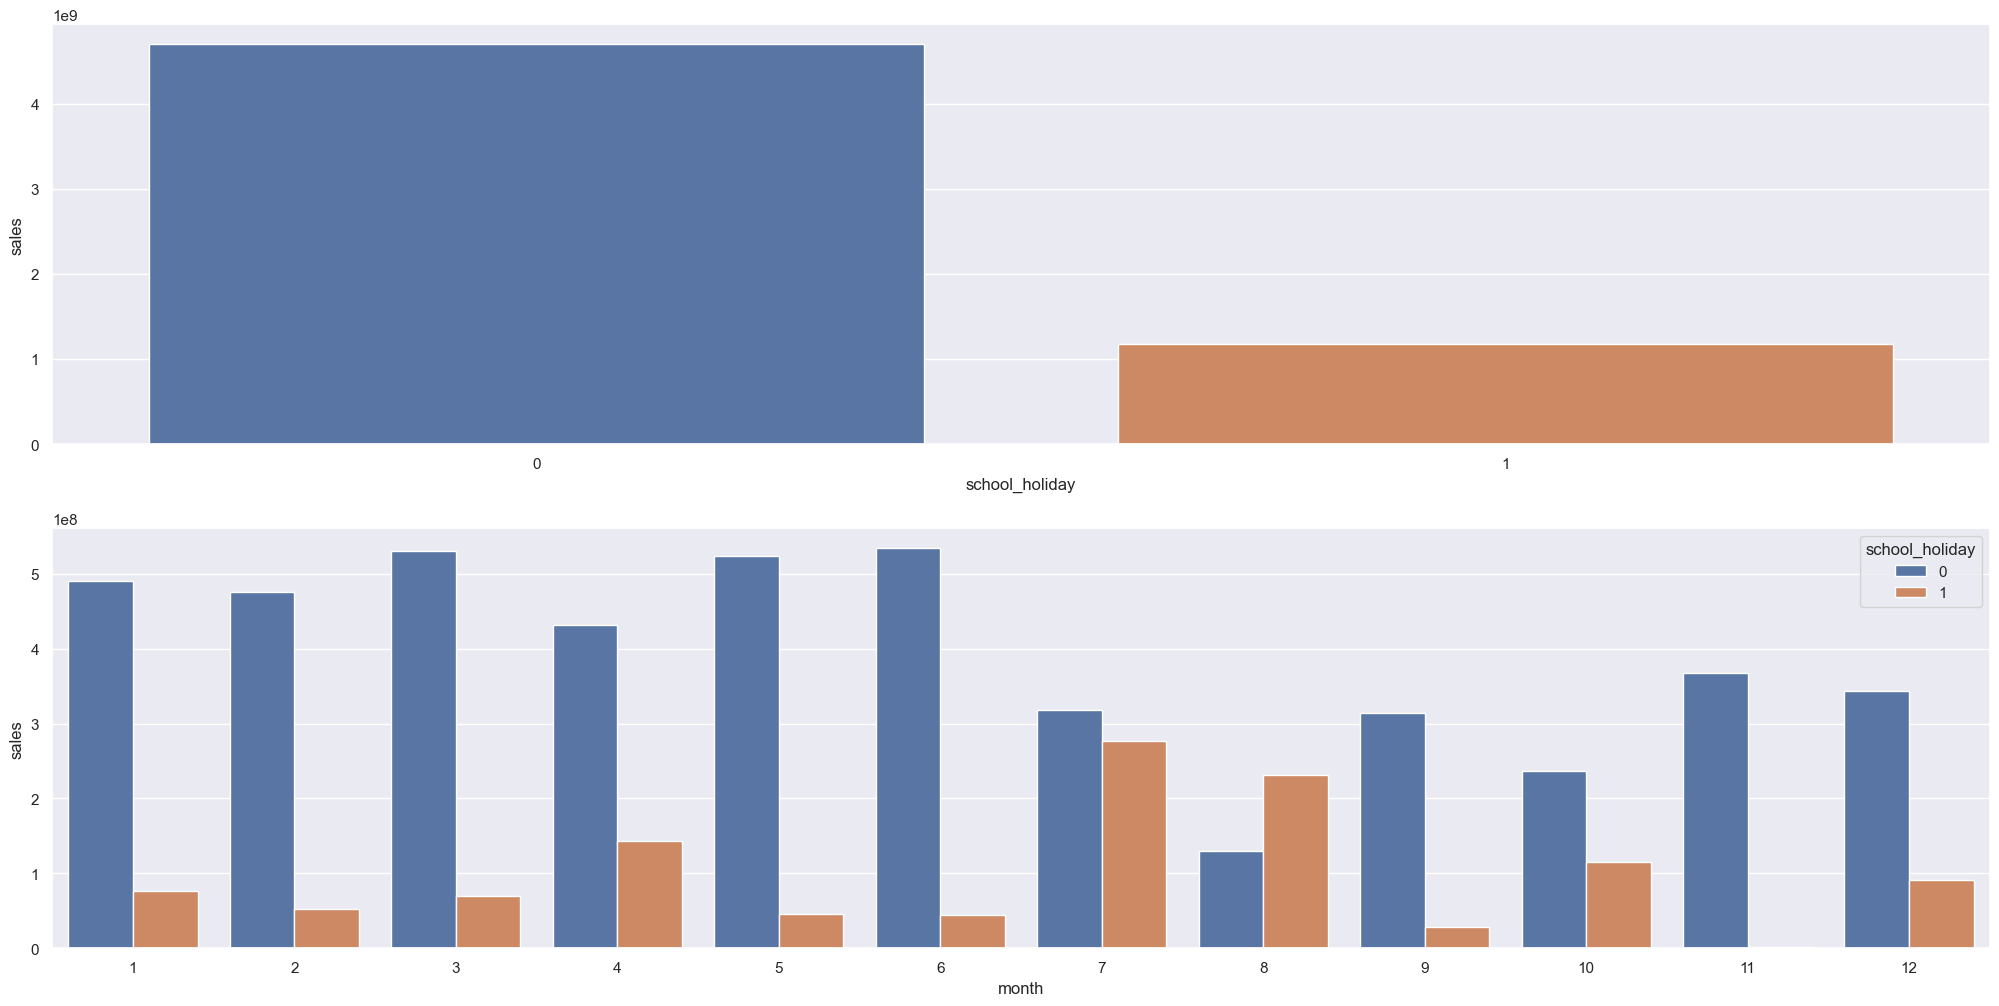

In [44]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y='sales', data=aux1);

plt.subplot(2,1,2)
aux2 = df4[['month','school_holiday', 'sales']].groupby(['month','school_holiday']).sum().reset_index()
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);

### 4.2.1. Resumo das Hipoteses

In [45]:
from tabulate import tabulate

In [46]:
pip install tabulate

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


## 4.1 Análise multivariada

### 4.3.1 Numerical Attributes

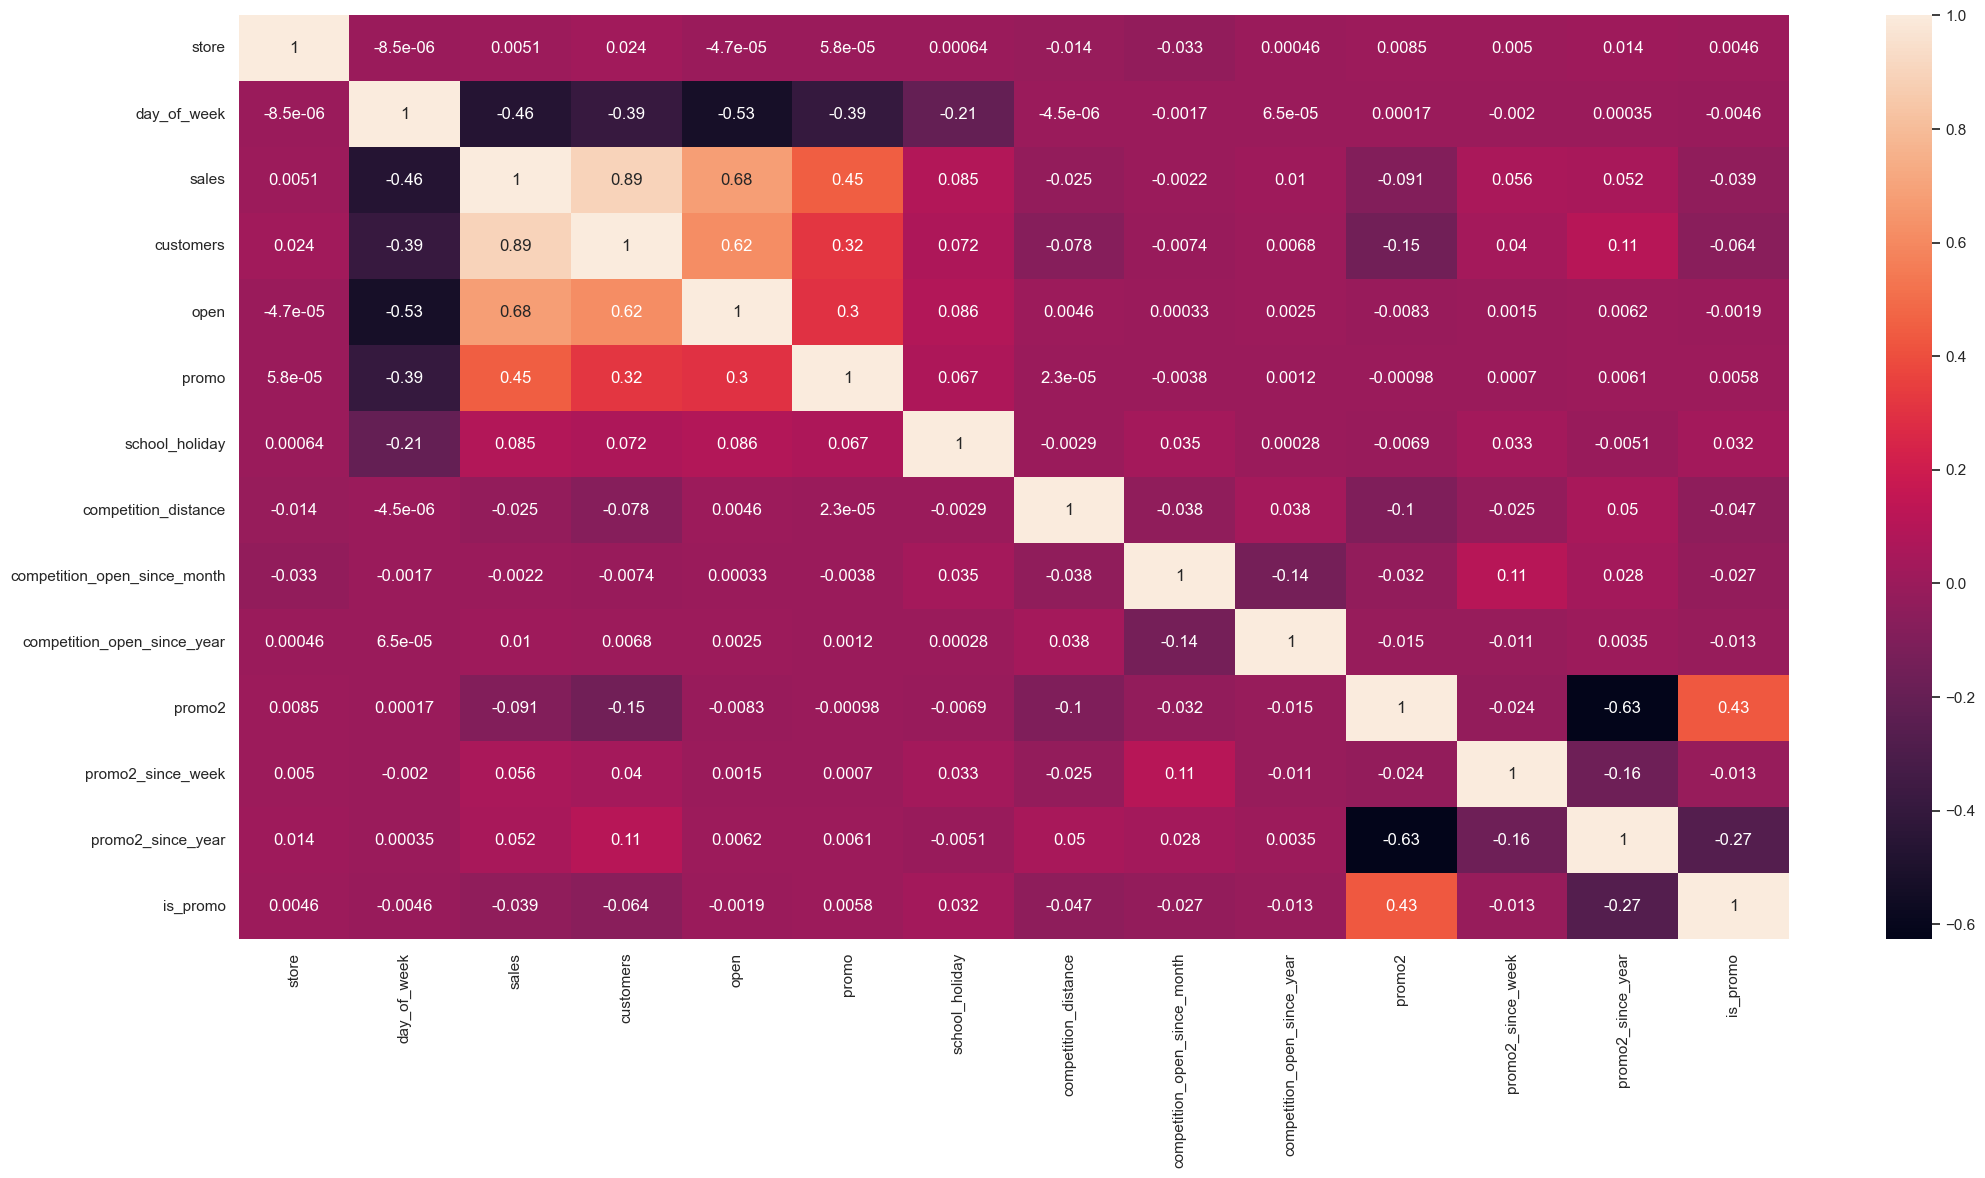

In [47]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

### 4.3.2 Categorical Attributes

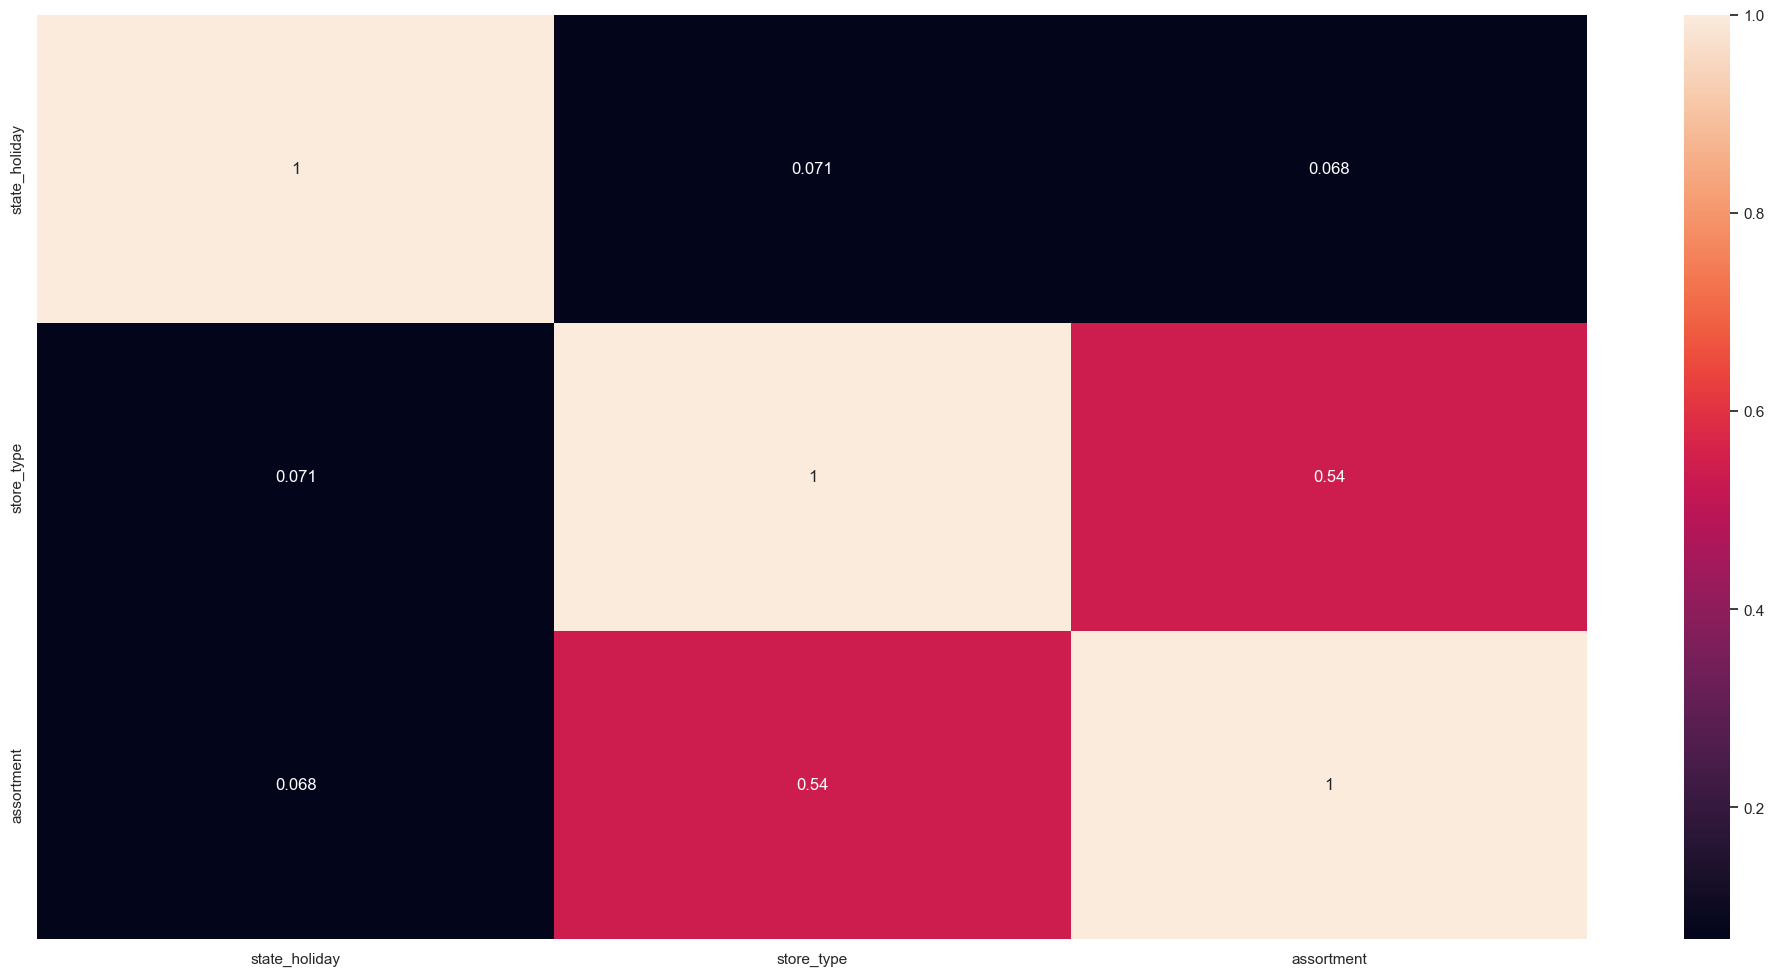

In [48]:
#only categorical data
a = df4.select_dtypes(include='object')

# Calculate cramer_V
a1 = cramer_v( a['state_holiday'], a['state_holiday'])
a2 = cramer_v( a['state_holiday'], a['store_type'])
a3 = cramer_v( a['state_holiday'], a['assortment'])

a4 = cramer_v( a['store_type'], a['state_holiday'])
a5 = cramer_v( a['store_type'], a['store_type'])
a6 = cramer_v( a['store_type'], a['assortment'])

a7 = cramer_v( a['assortment'], a['state_holiday'])
a8 = cramer_v( a['assortment'], a['store_type'])
a9 = cramer_v( a['assortment'], a['assortment'])

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 
               'store_type': [a4, a5, a6],
               'assortment': [a7, a8, a9] } )

d = d.set_index(d.columns)

sns.heatmap( d, annot=True);

# 5.0. PASSO 05 - DATA PREPARATION

In [49]:
df5 = df4.copy()

## 5.1. Normalizacao

## 5.2. Rescaling

In [50]:
a = df5.select_dtypes(include=['int64', 'float64'])

<AxesSubplot:xlabel='competition_distance'>

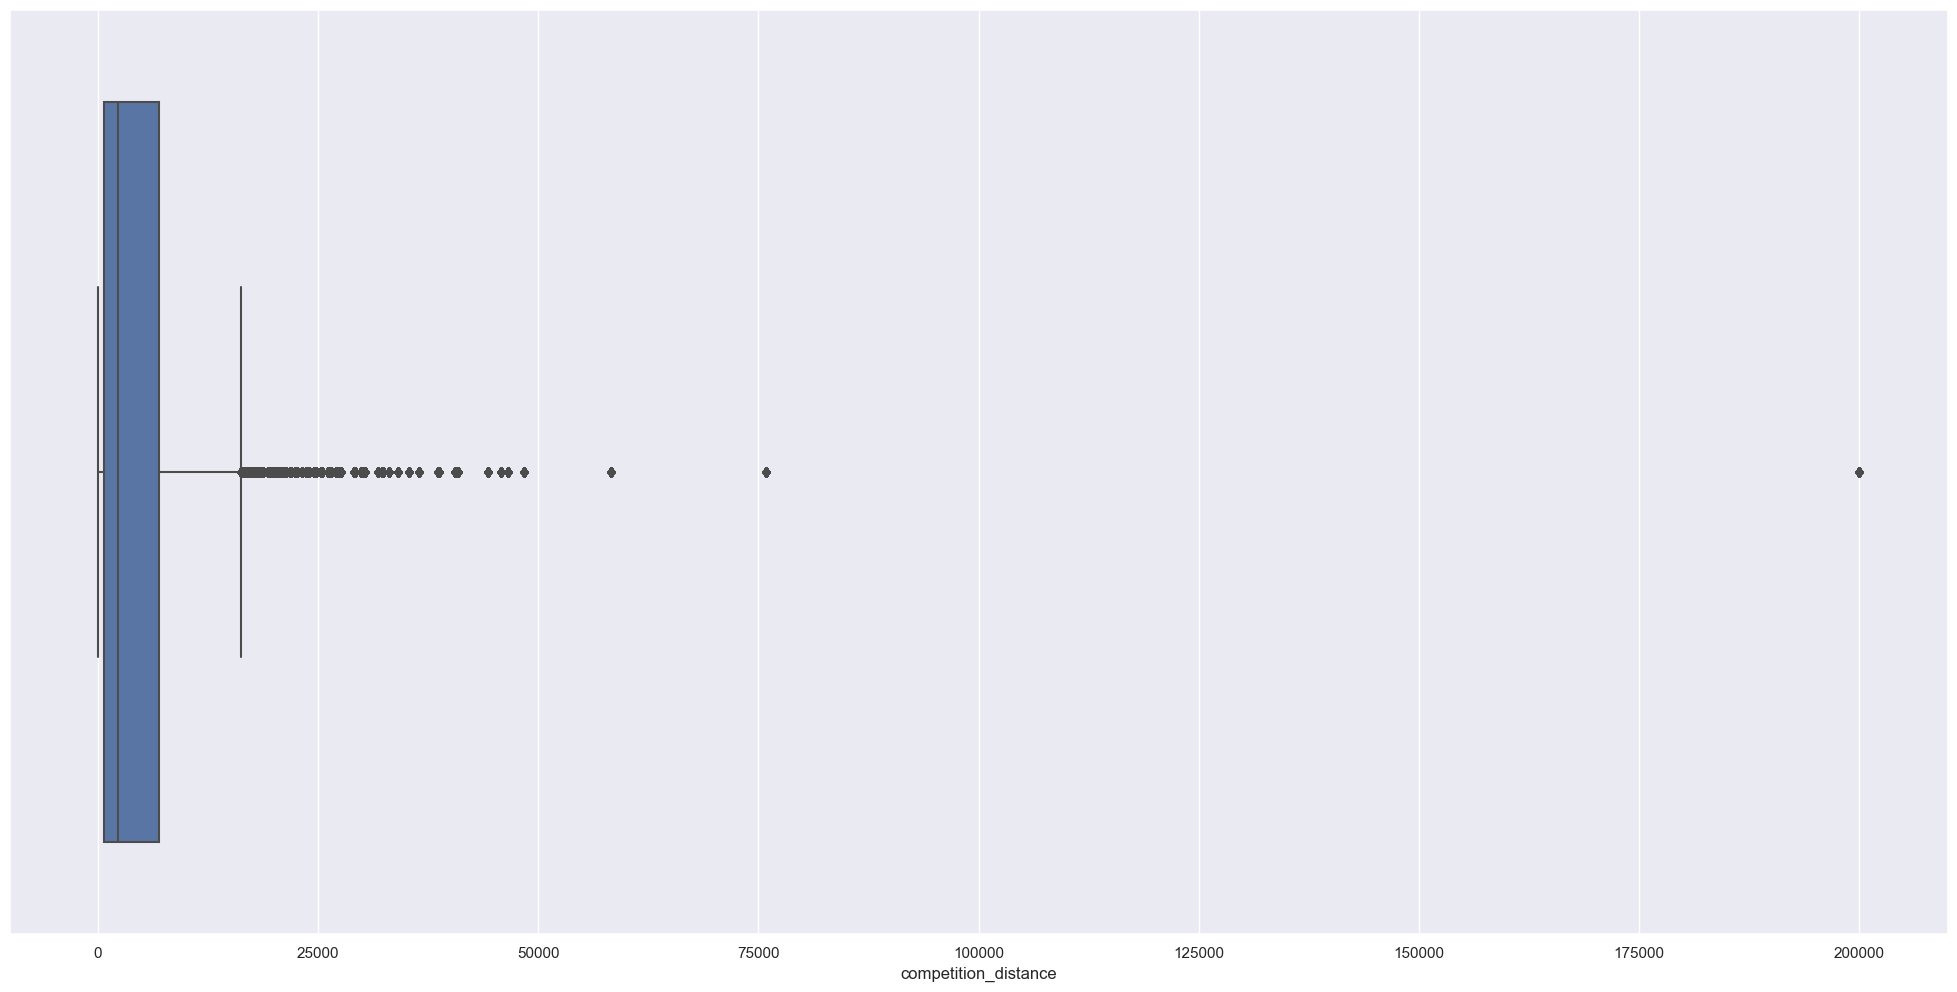

In [51]:
sns.boxplot( df5['competition_distance'] )

In [52]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values)
pickle.dump(rs, open( 'C:/Users/Leonardo2/Documents/repos/DS_producao/parameter/competition_distance_scaler.pkl', 'wb'))

# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values)
pickle.dump(rs, open( 'C:/Users/Leonardo2/Documents/repos/DS_producao/parameter/competition_time_month_scaler.pkl', 'wb'))

# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values)
pickle.dump(rs, open( 'C:/Users/Leonardo2/Documents/repos/DS_producao/parameter/promo_time_week_scaler.pkl', 'wb'))

# year
df5['year'] = mms.fit_transform( df5[['year']].values)
pickle.dump(rs, open( 'C:/Users/Leonardo2/Documents/repos/DS_producao/parameter/year_scaler.pkl', 'wb'))

## 5.3. Transformacao

### 5.3.1. Encoding

In [53]:
#state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - Labol Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'])
pickle.dump(le, open( 'C:/Users/Leonardo2/Documents/repos/DS_producao/parameter/store_type_scaler.pkl', 'wb'))

# assortment - Ordinal Encoding
assortment_dict = {'basic':1,'extra': 2,'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2 Response Variable Transformation

In [54]:
df5['sales'] = np.log1p( df5['sales'])

### 5.3.3 Nature Transformation

In [55]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12 ) ) )

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52 ) ) )


In [56]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_Christmas,state_holiday_Easter holiday,state_holiday_public holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.57,1,1,2,1,-0.17,9,2008,0,31,2015,0,1.00,7,31,31,2015-30,2008-09-01,0.92,2015-07-27,0.29,0,0,0,1,-0.97,-0.22,-0.50,-0.87,0.21,0.98,-0.57,-0.82
1,2,5,2015-07-31,8.71,1,1,0,1,-0.28,11,2007,1,13,2010,1,1.00,7,31,31,2015-30,2007-11-01,1.05,2010-03-22,0.92,0,0,0,1,-0.97,-0.22,-0.50,-0.87,0.21,0.98,-0.57,-0.82
2,3,5,2015-07-31,9.03,1,1,0,1,1.90,12,2006,1,14,2011,1,1.00,7,31,31,2015-30,2006-12-01,1.20,2011-03-28,0.80,0,0,0,1,-0.97,-0.22,-0.50,-0.87,0.21,0.98,-0.57,-0.82
3,4,5,2015-07-31,9.55,1,1,2,3,-0.28,9,2009,0,31,2015,0,1.00,7,31,31,2015-30,2009-09-01,0.74,2015-07-27,0.29,0,0,0,1,-0.97,-0.22,-0.50,-0.87,0.21,0.98,-0.57,-0.82
4,5,5,2015-07-31,8.48,1,1,0,1,4.45,4,2015,0,31,2015,0,1.00,7,31,31,2015-30,2015-04-01,-0.16,2015-07-27,0.29,0,0,0,1,-0.97,-0.22,-0.50,-0.87,0.21,0.98,-0.57,-0.82


# 6.0. PASSO 06 - FEATURE SELECTION

In [57]:
df6 = df5.copy()

## 6.1. Split dataframe into training and test dataset

In [58]:
cols_drop = ['week_of_year', 'day','month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6  = df6.drop(cols_drop, axis = 1)

In [59]:
 df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta( days=6*7 )

Timestamp('2015-06-19 00:00:00')

In [60]:
# trainning dataset
X_train = df6[df6['date'] < "2015-06-19"]
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= "2015-06-19"]
y_test = X_test['sales']

print( 'Training Min Date: {}'.format(X_train['date'].min( ) ) )
print( 'Training Max Date: {}'.format(X_train['date'].max( ) ) )

print( '\nTest Min Date: {}'.format(X_test['date'].min( ) ) )
print( 'Test Max Date: {}'.format(X_test['date'].max( ) ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2. Boruta as feature Selector

In [61]:
# trainning and test dataset for Boruta
#X_train_n = X_train.drop( ['date', 'sales'], axis=1).values
#Y_train_n = Y_train.values.ravel()

# define RandomForestRegressor
#rf = RandomForestRegressor( n_jobs=-1)

# define Boruta
#BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, Y_train_n)

## 6.2.1 Best Features from Boruta

In [62]:
#cols_selected = boruta_support_.tolist()

# best features
#X_train_fs = X_train.drop( ['date', 'sales'], axis=1)
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# note selected boruta
#cols_not_selected_boruta = list(np.setdiff1d( X_train_fs.columns, cols_selected_boruta))

## 6.3. Manual Feature Selection

In [63]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0. PASSO 07 - MACHINE LEARNING MODELING

In [64]:
x_train = X_train[ cols_selected_boruta]
x_test = X_test[ cols_selected_boruta]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

## 7.1. Average Model

In [65]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

#predicition
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename( columns={'sales': 'predicitions'} )
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predicitions']

#performance
baseline_result = ml_error( 'Average Model', np.expm1(y_test), np.exp(yhat_baseline) )
baseline_result

,Modelo Name,MAE,MAPE,RMSE
0,Average Model,1354.84,0.46,1835.02


## 7.2. Linear Regression Model

In [66]:
# model
lr = LinearRegression().fit( x_train, y_train)

# predicition
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1( y_test), np.expm1( yhat_lr))
lr_result

,Modelo Name,MAE,MAPE,RMSE
0,Linear Regression,1867.09,0.29,2671.05


### 7.2.1 Linear Regression Model - Cross Validation

In [67]:
#lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose=False)
#lr_result_cv

## 7.3. Linear Regression regularized Model - Lasso

In [68]:
# model
lrr = Lasso(alpha=0.01).fit( x_train, y_train)

# predicition
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1( y_test), np.expm1( yhat_lrr))
lrr_result

,Modelo Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.70,0.29,2744.45


### 7.3.1 Lasso - Cross Validation

In [69]:
#lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr, verbose=False)
#lrr_result_cv

## 7.4. Random Forest Regression

In [70]:
# model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit( x_train, y_train)

# predicition
yhat_rf = rf.predict(x_test)

# performance
rf_result = ml_error('Random Forest Regressor', np.expm1( y_test), np.expm1( yhat_rf))
rf_result

,Modelo Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.60,0.10,1011.12


### 7.4.1 Random Forest Regression - Cross Validation

In [71]:
#rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=True)
#rf_result_cv

## 7.5. XGBoost Regression

In [72]:
# model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                             #n_estimators=100,
                             #eta=0.01,
                             #max_depth=10,
                             #subsample=0.7,
                             colsample_bytree=0.9 ).fit( x_train, y_train)

# predicition
yhat_xgb = model_xgb.predict(x_test)

# performance
xgb_result = ml_error('XGBoost Regressor', np.expm1( y_test), np.expm1( yhat_xgb))
xgb_result


,Modelo Name,MAE,MAPE,RMSE
0,XGBoost Regressor,883.72,0.13,1274.23


### 7.5.1 XGBoost Regression - Cross Validation

In [73]:
#xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
#xgb_result_cv

## 7.6 Single performance

In [74]:
#modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result])
#modelling_result.sort_values('RMSE')

### 7.6 Real Performance - Cross Validation

In [75]:
#modelling_result = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
#modelling_result

# 8.0. PASSO 08 - HYPERPARAMETER FINE TUNING

## 8.1. Random Search

In [76]:
param = {
     'n_estimators': [1500, 1700, 2500, 3000, 3500],
     'eta': [0.01,0.03],
     'max_depth': [3, 5, 9],
     'subsample': [0.1,0.5, 0.7],
     'colsample_bytree': [0.1, 0.7, 0.9],
     'min_child_weight': [3, 8, 15]
         }
MAX_EVAL = 10         

In [77]:
# final_result = pd.DataFrame()
# 
# for i in range( MAX_EVAL ):
     # choose values for parameters randomly
#     hp = {k: random.sample(v, 1) [0] for k, v in param.items() }
#     print( hp )
     # model
#     model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
#                                  n_estimators=hp['n_estimators'],
#                                  eta=hp['eta'],
#                                  max_depth=hp['max_depth'],
#                                  subsample=hp['subsample'],
#                                  colsample_bytree=hp['colsample_bytree'],
#                                  min_child_weight=hp['min_child_weight'] )
#     
     # performance
#     result = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=False)
#     final_result = pd.concat( [final_result, result])
# 
# final_result

## 8.2 Final Model

In [78]:
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3
        }      

In [79]:
#model
model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
                                   n_estimators=param_tuned['n_estimators'],
                                   eta=param_tuned['eta'],
                                   max_depth=param_tuned['max_depth'],
                                   subsample=param_tuned['subsample'],
                                   colsample_bytree=param_tuned['colsample_bytree'],
                                   min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train)
#prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test)

#performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned) )
xgb_result_tuned

,Modelo Name,MAE,MAPE,RMSE
0,XGBoost Regressor,770.21,0.12,1108.06


In [80]:
mpe = mean_percentage_error ( np.expm1(y_test), np.expm1(yhat_xgb_tuned) )
mpe

-0.01598888634252212

In [81]:
importances = model_xgb_tuned.feature_importances_

In [82]:
importance_df = pd.DataFrame({'Feature': x_train.columns, 'Importance': importances})

In [83]:
importance_df = importance_df.sort_values(by='Importance', ascending=False)

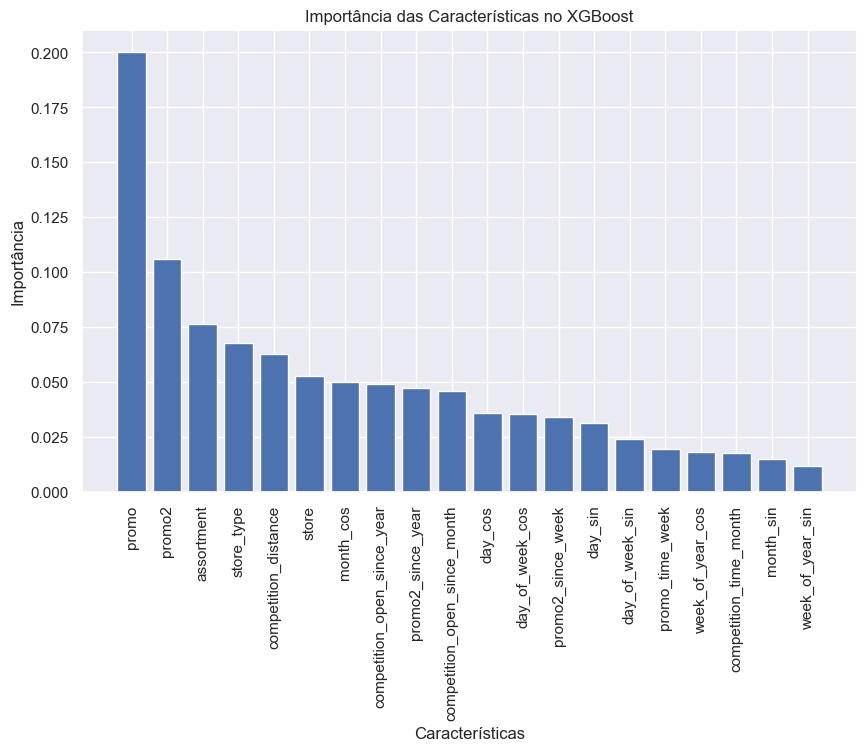

In [84]:
plt.figure(figsize=(10, 6))
plt.bar(range(len(importance_df)), importance_df['Importance'])
plt.xticks(range(len(importance_df)), importance_df['Feature'], rotation='vertical')
plt.xlabel('Características')
plt.ylabel('Importância')
plt.title('Importância das Características no XGBoost')
plt.show()

# 9.0. PASSO 09 - TRADUCAO E INTERPRETACAO DO ERRO

In [85]:
df9 = X_test[ cols_selected_boruta_full ]

# rescale
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )

## 9.1. Business Performance

In [86]:
# sum of predictions

df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

# Scnearios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# Order Columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]


In [87]:
df92.sort_values('MAPE', ascending=False).sample(10)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
232,233,347882.69,347073.20,348692.17,809.48,0.09
640,641,213833.00,213126.38,214539.62,706.62,0.16
681,682,444804.41,443694.93,445913.88,1109.48,0.09
1053,1054,231380.31,230802.13,231958.50,578.19,0.09
515,516,226636.11,225991.75,227280.47,644.36,0.13
281,282,169136.58,168772.20,169500.96,364.38,0.08
279,280,238342.69,237925.04,238760.34,417.65,0.07
726,727,173362.36,173000.28,173724.44,362.08,0.08
295,296,258377.30,257844.58,258910.01,532.71,0.09
1102,1103,202521.48,201916.72,203126.25,604.77,0.10


In [88]:
df92['MAPE'].mean()

0.11599107144666598

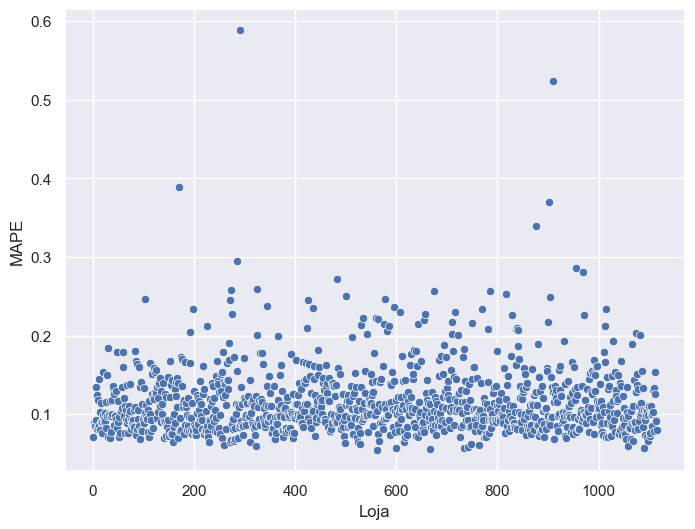

In [89]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='store', y='MAPE', data=df92);
# Defina os rótulos dos eixos x e y
plt.xlabel('Loja')
plt.ylabel('MAPE')

# Mostre o gráfico
plt.show()
 

## 9.2. Total Performance

In [90]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index':'Scenario', 0:'Values'})
df93['Values'] = df93['Values'].map('R${:,.2f}'.format)
df93

,Scenario,Values
0,predictions,"R$285,817,920.00"
1,worst_scenario,"R$284,955,855.77"
2,best_scenario,"R$286,679,971.85"


## 9.3. Machine Learning Performance

In [91]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

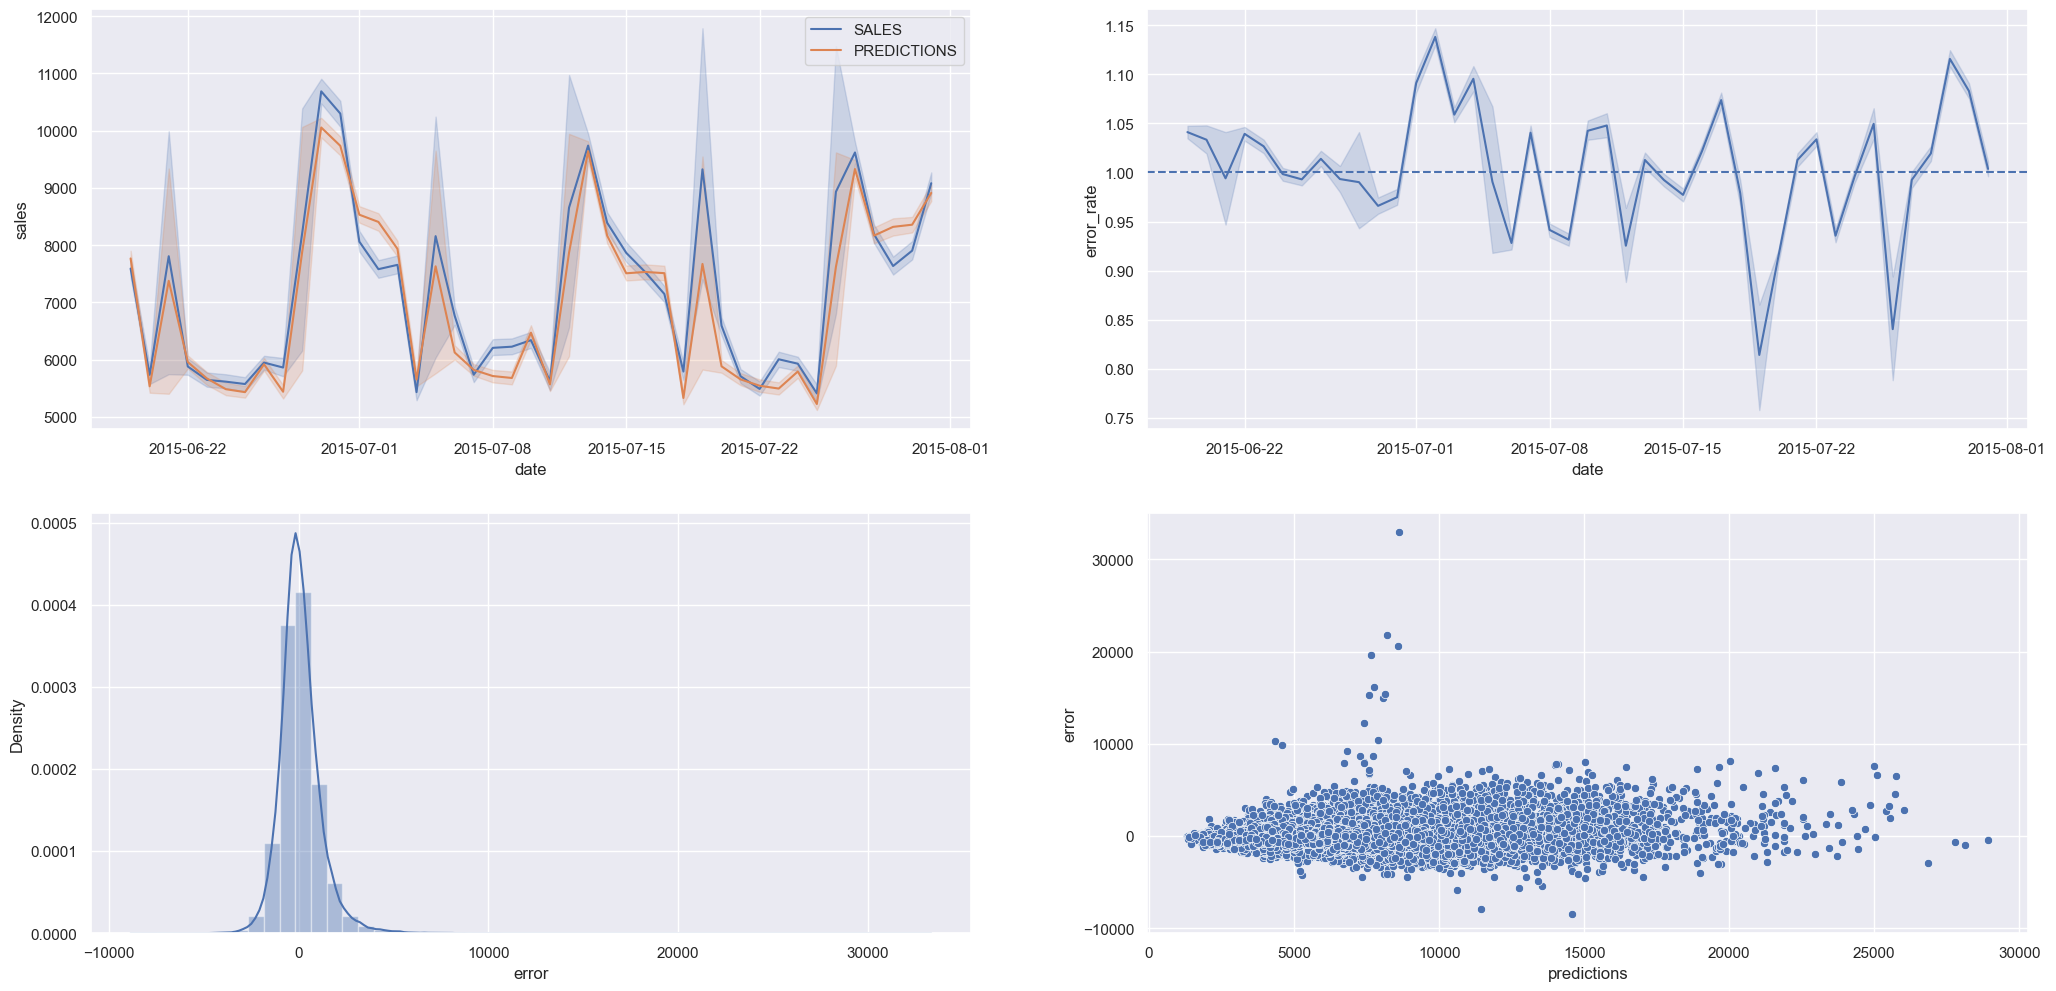

In [92]:
plt.rcParams.update({'font.size': 14})
plt.subplot(2, 2, 1)
sns.lineplot( x='date', y='sales', data=df9, label='SALES');
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS');

plt.subplot(2, 2, 2)
sns.lineplot( x='date', y='error_rate', data=df9);
plt.axhline(1, linestyle='--')

plt.subplot(2, 2, 3)
sns.distplot(df9['error']);

plt.subplot(2, 2, 4)
sns.scatterplot(x='predictions', y='error', data=df9);

# 10.0. PASSO 10 -  DEPLOY MODEL TO PRODUCTION

In [93]:
# Save Trained Model
pickle.dump( model_xgb_tuned, open( 'C:/Users/Leonardo2/Documents/repos/DS_producao/model/model_rossmann.pkl', 'wb'))

## 10.1. Rossmann Class

In [94]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann( object ):
    def __init__( self ):
        self.home_path='C:/Users/Leonardo2/Documents/repos/DS_producao/'
        self.competition_distance_scaler   = pickle.load( open( self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb') ) 
        self.competition_time_month_scaler = pickle.load( open( self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler        = pickle.load( open( self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler                   = pickle.load( open( self.home_path + 'parameter/year_scaler.pkl', 'rb'))
        self.store_type_scaler             = pickle.load( open( self.home_path + 'parameter/store_type_scaler.pkl', 'rb'))
        
    def data_cleaning(self, df1):
        
        ## 1.1 Rename Columns

        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo','StateHoliday', 'SchoolHoliday',
                    'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear',
                    'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore(x)

        cols_new = list(map (snakecase, cols_old))
                
        #rename
                
        df1.columns = cols_new

        ## 1.3 Data types
        
        df1['date'] = pd.to_datetime(df1['date'])
        
        
        ## 1.5 Fillout NA
        
        #competition_distance
        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan(x) else x)
        
        #competition_open_since_month   
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan( x['competition_open_since_month']) else x["competition_open_since_month"], axis = 1)
        
        #competition_open_since_year    
        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)
                               
        # promo2_since_week  
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan( x['promo2_since_week']) else x['promo2_since_week'], axis = 1)
        
        # promo2_since_year    
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['promo2_since_year']) else x['promo2_since_year'], axis = 1)
        
        # promo_interval
        month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
        
        df1['promo_interval'].fillna(0, inplace = True)
        
        df1['month_map'] = df1['date'].dt.month.map(month_map)
        
        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis =1)


        ## 1.6 Change Types
        # competition
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( 'int64' )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( 'int64' )
        
        # promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
        df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

        return df1
        
    def feature_engineering(self , df2 ):
        
        # year
        df2['year'] = df2['date'].dt.year
        
        # month
        df2['month'] = df2['date'].dt.month
        
        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        #df2['week_of_year'] = df2['date'].dt.weekofyear
        df2['week_of_year'] = df2['date'].dt.isocalendar().week.astype('int64')
        # year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W')

        # competition since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis =1)
        df2['competition_time_month'] = ( (df2['date'] - df2['competition_since']) / 30 ).apply(lambda x: x.days).astype( 'int64' )
        
        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
        
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta( days = 7))
        
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'])/7 ). apply(lambda x: x.days).astype('int64')
        
        # assortment
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')
        
        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public holiday' if x == 'a' else 'Easter holiday' if x == 'b' else 'Christmas' if x == 'c' else 'regular_day')


        # 3.0 PASSO 03 - FILTRAGEM DE VARIÁVEIS
        
        ## 3.1 Filtragem as linhas

        df2 = df2[df2['open'] != 0]

        ## 3.2 Selecao das Colunas

        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop, axis=1)

        return df2
    
    def data_preparation( self, df5):
        
        ## 5.2 Rescaling
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values)
        
        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values)
                
        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values)
                
        # year
        df5['year'] = self.year_scaler.fit_transform( df5[['year']].values)

        ### 5.3.1. Encoding
        #state_holiday - One Hot Encoding
        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

        # store_type - Labol Encoding
        le = LabelEncoder()
        df5['store_type'] = self.store_type_scaler.fit_transform( df5['store_type'])
        
        # assortment - Ordinal Encoding
        assortment_dict = {'basic':1,'extra': 2,'extended': 3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)

        ### 5.3.3 Nature Transformation
        
        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7 ) ) )
        
        # month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12 ) ) )
        
        # day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30 ) ) )
        
        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52 ) ) )
        
        cols_selected = [ 'store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 
                'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week', 
                'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']

         
        return df5[ cols_selected ]
    
    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict( test_data)
        
        # join pred into the original data
        original_data['prediction'] = np.expm1( pred )
        
        return original_data.to_json(orient='records', data_format='iso')

## 10.1. API Handler

In [96]:
import pickle
import pandas as pd
from flask             import Flask, request, Response
from rossmann.Rossmann import Rossmann

# load model
model = pickle.load(open ('C:/Users/Leonardo2/Documents/repos/DS_producao/model/model_rossmann.pkl', 'rb') )

# initializaze API
app = Flask( __name__)

@app.route( '/rossman/predict', methods=['POST'] )
def rossman_predict():
    test_json = request.get_json()
    
    if test_json: #there is data
        
        if isinstance( test_json, dict): # Unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # Multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
        
        # Instantiate Rossman Class
        pipeline = Rossman()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.features_engineerinf( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation(df2)
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
        
    else:
        return Response( '{}', status=200, minetype='application/json' )
    
if __name__ == '__main__':
    app.run( '0.0.0.0')

ModuleNotFoundError: No module named 'rossmann'

## 10.2. API Tester

In [97]:
import requests
import json

In [98]:
# loading test dataset
df10 = pd.read_csv('C:/Users/Leonardo2/Documents/repos/DS_producao/data/test.csv' )

In [99]:
# merge test dataset + store
df_test = pd.merge( df10, df_store_raw, how='left', on='Store')

# choose store for prediction
df_test = df_test[df_test['Store'] == 24]

# remove closed days
df_test = df_test[df_test['Open'] != 0 ]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis=1) 


In [103]:
#df_test.sample(10)

In [101]:
# convert DataFrame to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [102]:
# API Call
#url = 'http://192.168.0.109:5000/rossmann/predict'
url = 'https://rossmann-telegram-bot-3dn2.onrender.com'
header = {'Content-type': 'application/json'}
data = data

r = requests.post( url, data=data, headers = header)
print('Status Code {}'.format( r.status_code) ) 

Status Code 500


In [ ]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [ ]:
d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()

for i in range( len( d2 ) ):
    print( 'Store Number {} will sell R${:,.2f} in the next 6 weeks'.format( 
            d2.loc[i, 'store'], 
            d2.loc[i, 'prediction'] ) )

In [ ]:
d1.head()

In [ ]:
pip show json

In [ ]:
pip show os